# IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import statistics as st

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

import optuna
from sklearn.linear_model import Lasso, Ridge, ElasticNet


from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


from sklearn.metrics import mean_absolute_percentage_error
import optuna.visualization


import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# LOAD DATA

In [17]:
#load the data

data = pd.read_csv('../data/cleaned/data_final.csv')
dataCpy = data.copy()

# 1) Define the objective of the regression: 


- Objective: our regression model will predict the announcement price of your house with the house data as input. 
- Target feature: price
- We will use R2 (for evaluating generalization capacity of the model) and MAE (for evaluating precision of the model)


But.... what would be an acceptable maximum MAE?

In [18]:
#Since the target feature is the price, the MAE will be in € units.

#AN OPTION WOULD BE: 

#1.We will get which is the standard deviation of "price" feature 
std_price = dataCpy["price"].std()
print(f"Standard deviation of the feature 'price': {round(std_price,2)}€") #--> The values of "price" differ from the mean: 310649.51€

#2.The maximum accepatble MAE could be a percentage of that standard deviation value. 
#In the house business, 31.000€ more or less expensive may have an impact on buyers, however a price of 10.000€ may not have so much impact. 
#So an acceptale MAE will be 10.000€ for all the predictions. 





Standard deviation of the feature 'price': 310775.75€


HOWEVER: 

The first option would be easier to implement (1 fixed maximum MAE for all the predictions). However, this would not be true. 
Since 10.000€ may not have an impact (would be an acecptable MAE) for a house of 500.000€ for example, but would have a big 
impact (would NOT be an acceptable MAE) for a house of 50.000€.

So we instead of MAE, will take into account the "relative MAE"; this is, the MAPE (Mean Absolute Percentage Error) with a maximum acceptable error of 10%. So for example: 

In [19]:

print(f"Cheapest House: {round(min(dataCpy["price"]),2)}€")
print(f"10% = {round(min(dataCpy["price"])*0.1,2)}€\n")

print(f"Most Expensive House: {round(max(dataCpy["price"]),2)}€")
print(f"10% = {round(max(dataCpy["price"])*0.1,2)}€\n")

print(f"Average price House: {round(st.mean(dataCpy["price"]),2)}€")
print(f"10% = {round(st.mean(dataCpy["price"])*0.1,2)}€\n")



Cheapest House: 50000.0€
10% = 5000.0€

Most Expensive House: 2500000.0€
10% = 250000.0€

Average price House: 476994.44€
10% = 47699.44€



# 2) Data cleaning for the model

In [20]:
#1.We will check if there are any outliers in the values of "price"

#1.1 First we will see if there are univariate outliers in the feature price
Q1 = dataCpy['price'].quantile(0.25)
Q3 = dataCpy['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = dataCpy[(dataCpy['price'] < Q1 - 1.5*IQR) | (dataCpy['price'] > Q3 + 1.5*IQR)]

print(f"Univariate Outliers: {outliers.head()}") #Here we get some houses with a very expensive price, however they are not really outliers (nor strange values), they are just expensive houses which we must also take into account.

#1.2 Second we will see if there are multivariate outliers

iso = IsolationForest(contamination=0.01, random_state=42)
numerical_features = dataCpy.select_dtypes(include=np.number)
outliers_IF = iso.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_IF_df = dataCpy[outliers_IF == -1]

print("Isolation Forest - solo outliers:")
print(outliers_IF_df)


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers_LOF = lof.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_LOF_df = dataCpy[outliers_LOF == -1]

print("LOF - solo outliers:")
print(outliers_LOF_df)

#As we can see these are not outliers (there are not strange values), they are just expensive or houses with different features. We will maintain them.



Univariate Outliers:                                                url      price      zone  \
78   https://www.idealista.com/inmueble/108492917/  1400000.0    deusto   
114  https://www.idealista.com/inmueble/105222282/  2500000.0  uribarri   
137  https://www.idealista.com/inmueble/108035998/  1180000.0  uribarri   
148  https://www.idealista.com/inmueble/108037499/  1190000.0  uribarri   
185   https://www.idealista.com/inmueble/32760790/  1400000.0  uribarri   

                        neighborhood  built_area  usable_area  bedrooms  \
78                 Arangoiti, Bilbao       351.0        350.0         4   
114  Campo Volantin-Castaños, Bilbao       426.0        384.0         8   
137  Campo Volantin-Castaños, Bilbao       114.0         95.0         3   
148  Campo Volantin-Castaños, Bilbao       250.0        230.0         4   
185                 Uribarri, Bilbao       426.0        350.0         8   

     bathrooms  floor  exterior  ...  garage  storage_room  balcony    new  \

# 3) EDA 


- To evaluate if a linear regression model can accurately capture the relationship between the features and the target, before training any model.

UNIVARIATE------------------------------------
Target - Estadísticas generales:
count    1.229000e+03
mean     4.769944e+05
std      3.107758e+05
min      5.000000e+04
25%      2.650000e+05
50%      3.950000e+05
75%      5.990000e+05
max      2.500000e+06
Name: price, dtype: float64

Skew: 2.109654537879016
Kurtosis: 6.894991473049991


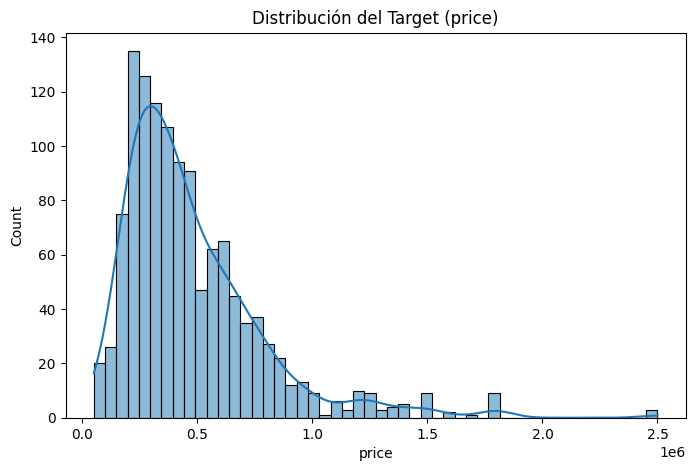


Feature: built_area
count    1229.000000
mean      114.688365
std        66.047508
min        30.000000
25%        72.000000
50%        98.000000
75%       134.000000
max       760.000000
Name: built_area, dtype: float64


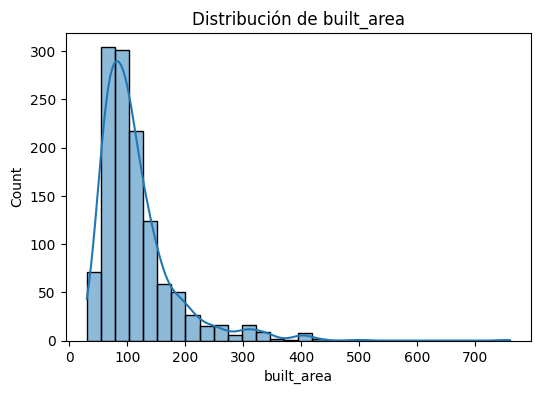


Feature: usable_area
count    1229.000000
mean      102.855134
std        60.286864
min        26.336611
25%        65.000000
50%        85.000000
75%       120.000000
max       706.012840
Name: usable_area, dtype: float64


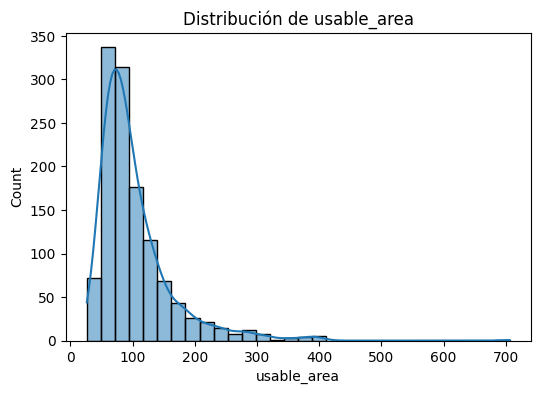


Feature: bedrooms
count    1229.000000
mean        3.068348
std         1.434867
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: bedrooms, dtype: float64


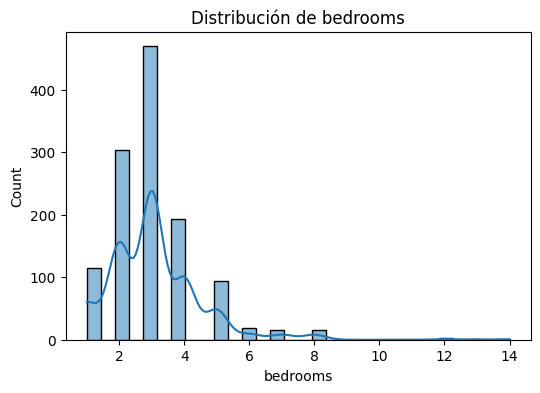


Feature: bathrooms
count    1229.000000
mean        1.768104
std         0.785096
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: bathrooms, dtype: float64


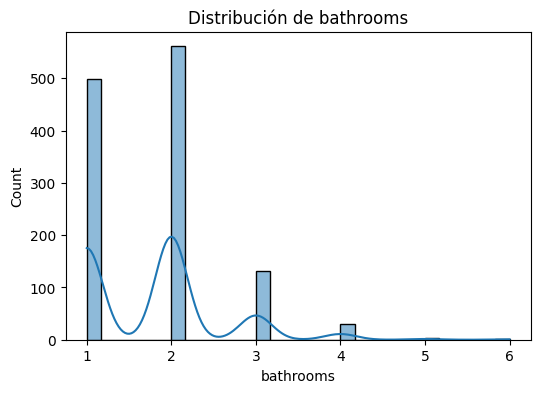


Feature: floor
count    1229.000000
mean        3.696908
std         3.102530
min        -1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        35.000000
Name: floor, dtype: float64


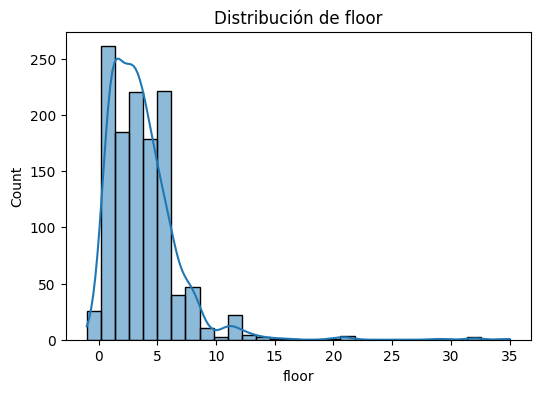


Feature: year
count    1229.000000
mean     1961.676159
std        37.060905
min      1800.000000
25%      1941.000000
50%      1963.000000
75%      1980.000000
max      2025.000000
Name: year, dtype: float64


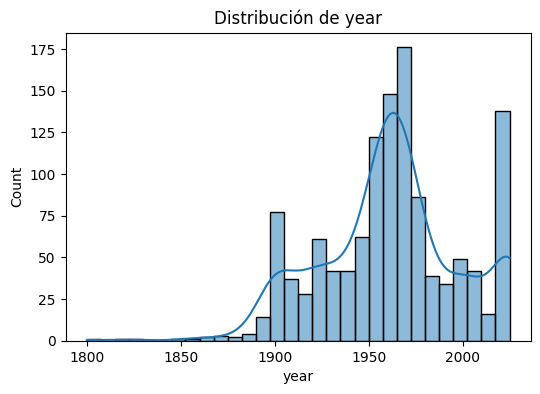

BIVARIATE------------------------------------


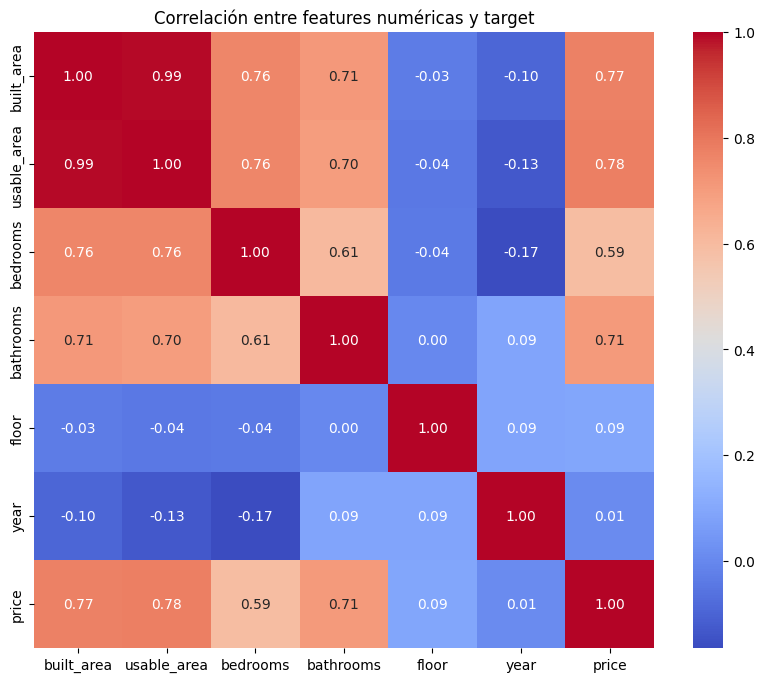

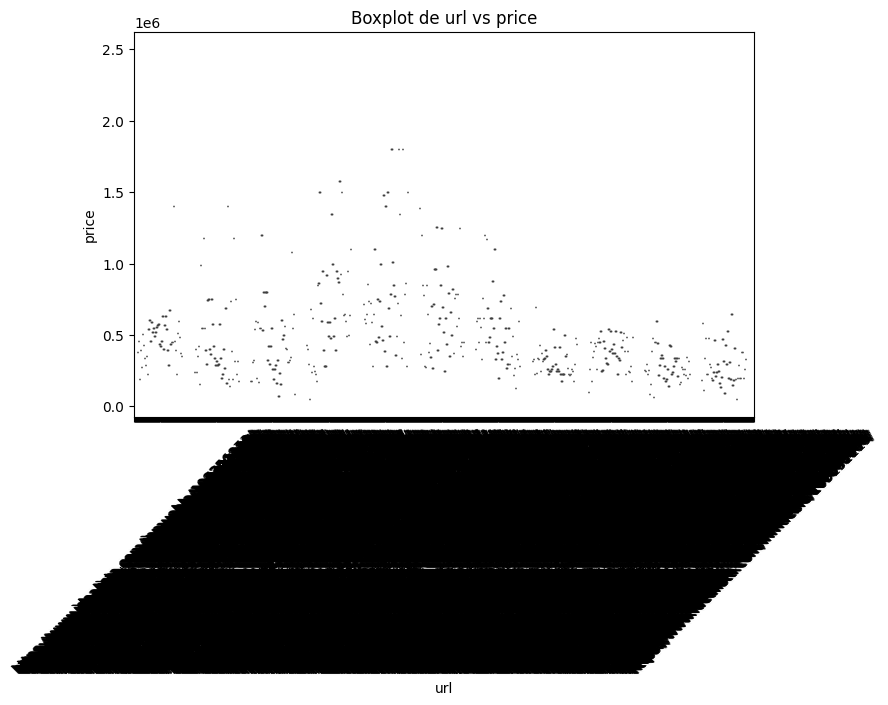

C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_26860\2535576384.py:66: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


ANOVA url vs price: F=nan, p=nan


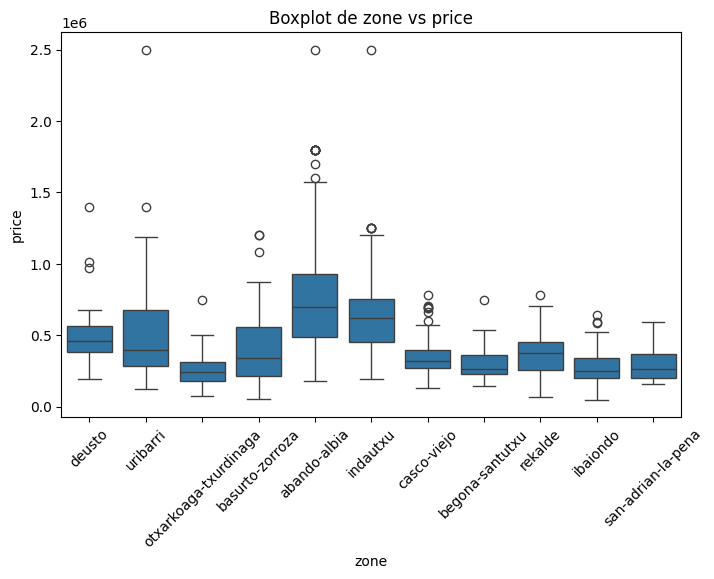

ANOVA zone vs price: F=62.03, p=0.0000


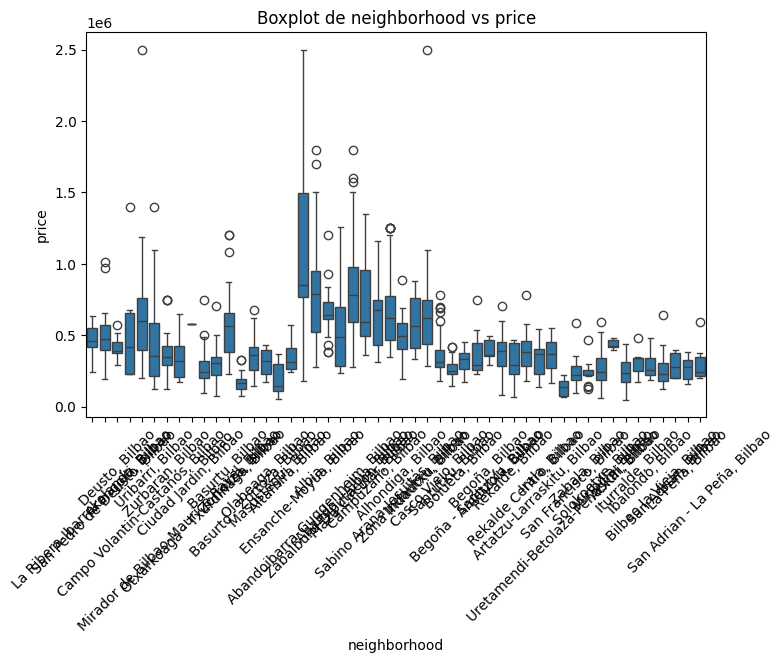

ANOVA neighborhood vs price: F=20.23, p=0.0000


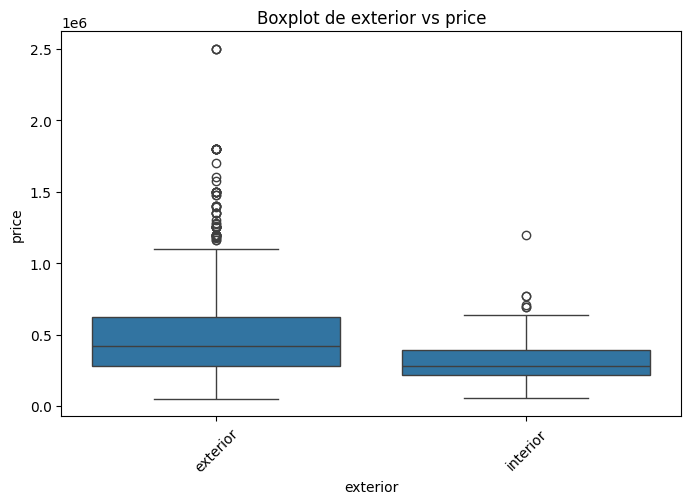

ANOVA exterior vs price: F=48.62, p=0.0000


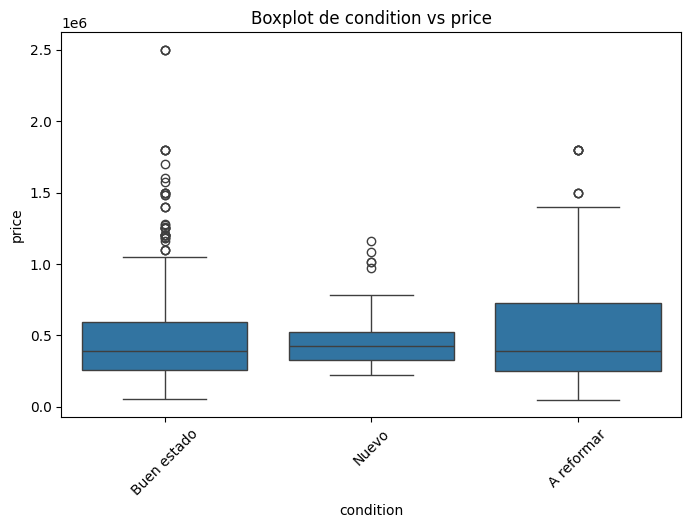

ANOVA condition vs price: F=3.40, p=0.0336


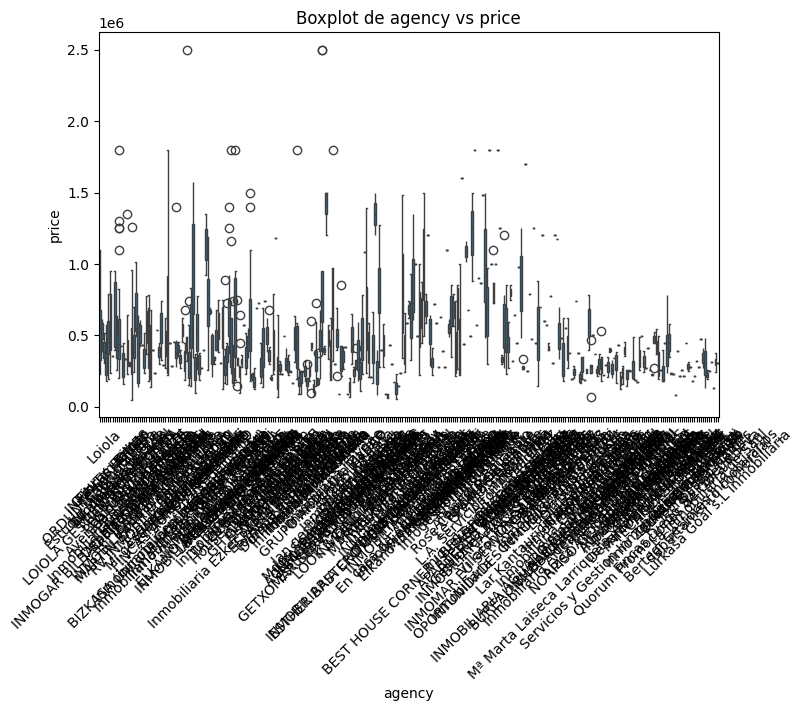

ANOVA agency vs price: F=3.05, p=0.0000


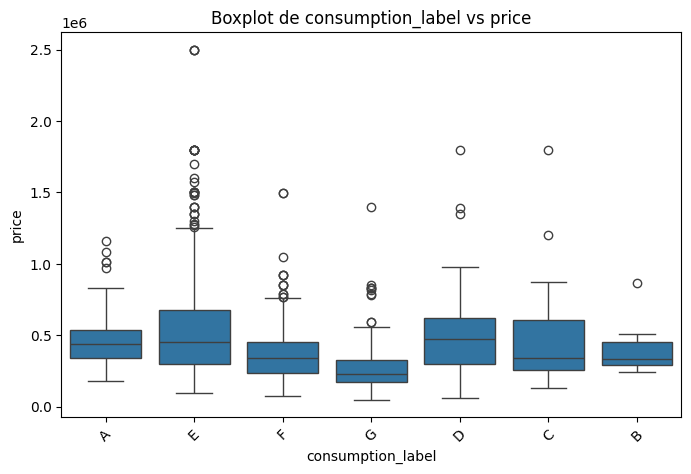

ANOVA consumption_label vs price: F=22.76, p=0.0000


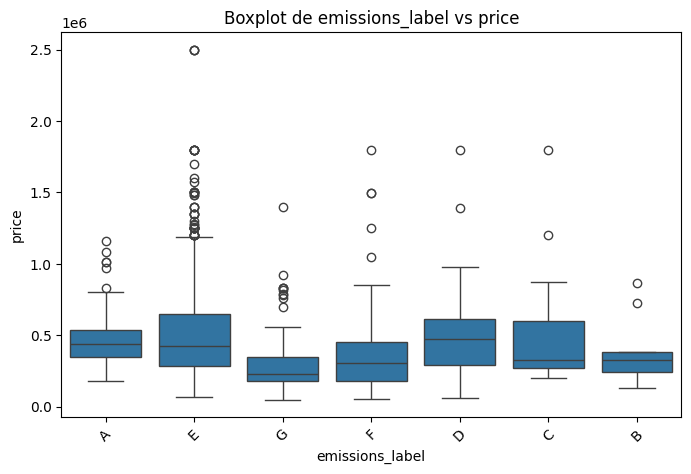

ANOVA emissions_label vs price: F=10.91, p=0.0000
DETECT NON LINEARITY------------------------------------


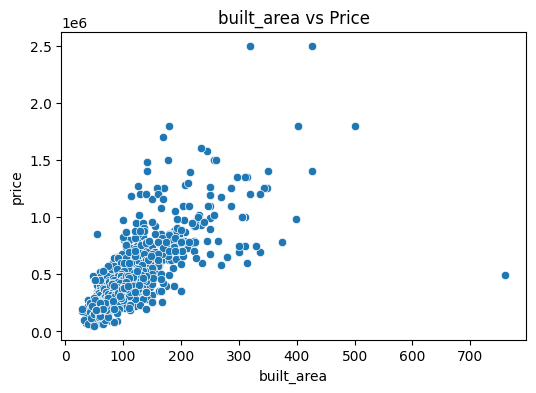

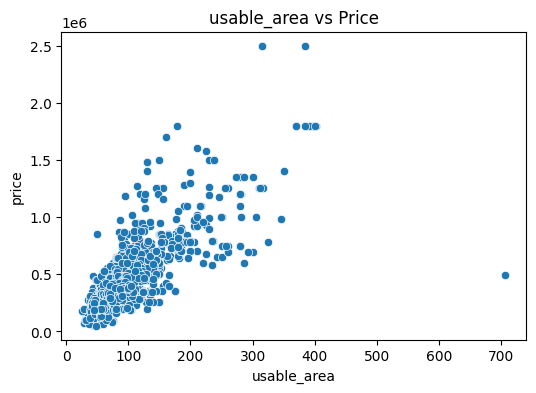

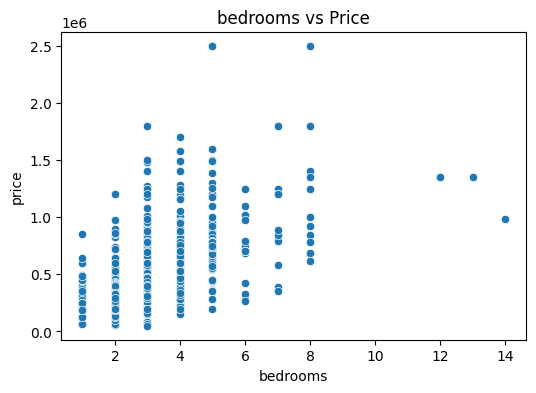

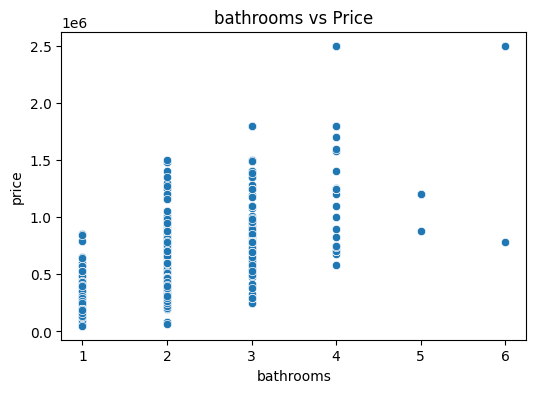

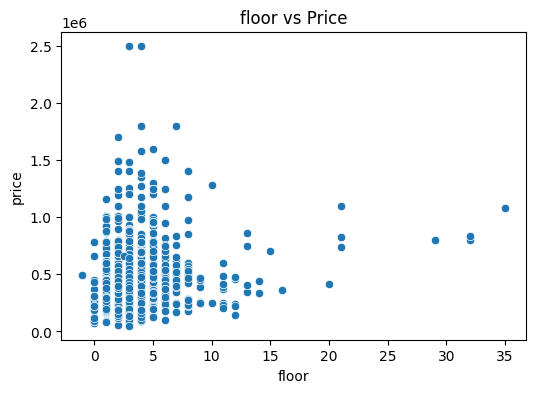

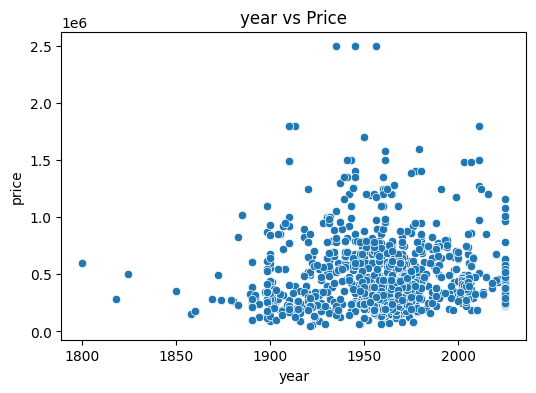

In [ ]:


print("UNIVARIATE------------------------------------")
# Target statistics
print("Target - Estadísticas generales:")
print(dataCpy['price'].describe())
print("\nSkew:", dataCpy['price'].skew())
print("Kurtosis:", dataCpy['price'].kurtosis())

# target histogram
plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price'], bins=50, kde=True)
plt.title("Distribución del Target (price)")
plt.show()

# Numeric features statistics and histograms
numerical_features = dataCpy.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('price')  

for col in numerical_features:
    print(f"\nFeature: {col}")
    print(dataCpy[col].describe())
    plt.figure(figsize=(6,4))
    sns.histplot(dataCpy[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

#
print("BIVARIATE------------------------------------")

# Correlation between feature and target (for numerical features)
corr = dataCpy[numerical_features + ['price']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y target")
plt.show()

# Correlation between feature and target (for categorical features)
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  # no usar la descripción de momento

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price")
    plt.xticks(rotation=45)
    plt.show()



print("DETECT NON LINEARITY------------------------------------")

# Scatterplots features vs target (numerical)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price', data=dataCpy)
    plt.title(f"{col} vs Price")
    plt.show()



As we can see in these results, the distribution of the target (price) is very skewed, which may be the reason of non linearity (or not clear linearity) with features like: floor or year.
So we will apply a logarithmic transformation to the target feature price. This should: 
- Improve futre heterodasdicity
- Improve current possible outliers 
- Improve linearity between features 

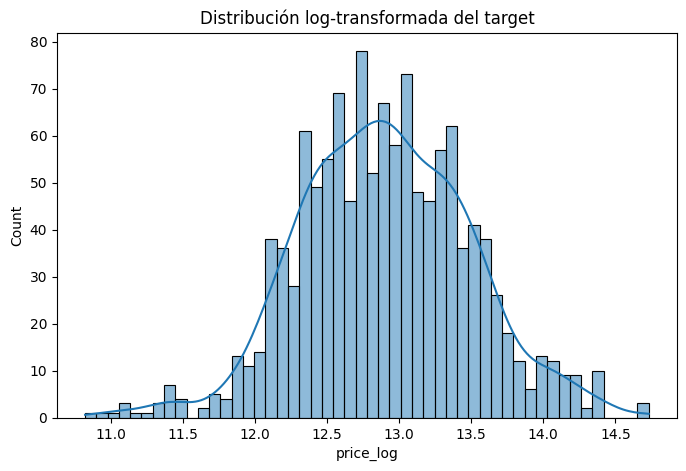


Skew: -0.0021085746449260837
Kurtosis: 0.29523924736662055
BIVARIATE------------------------------------


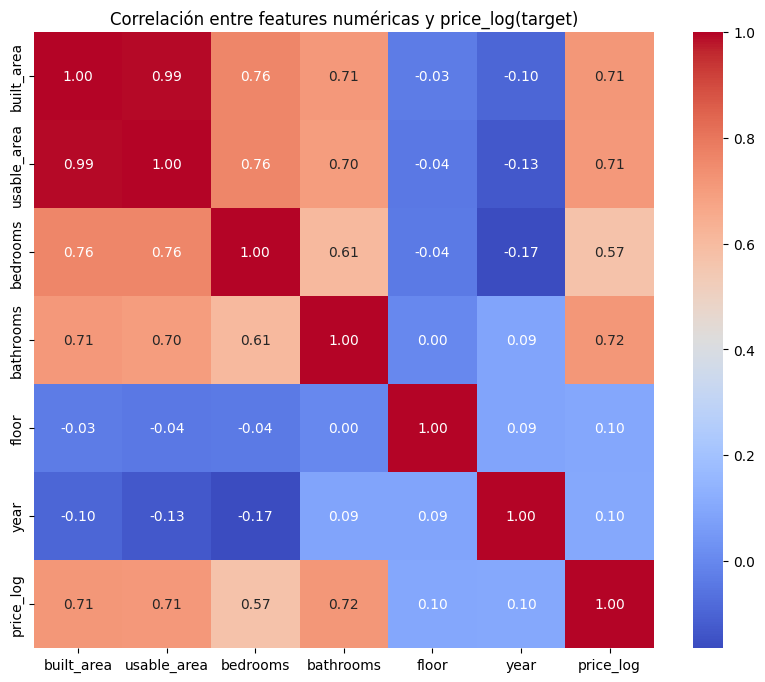

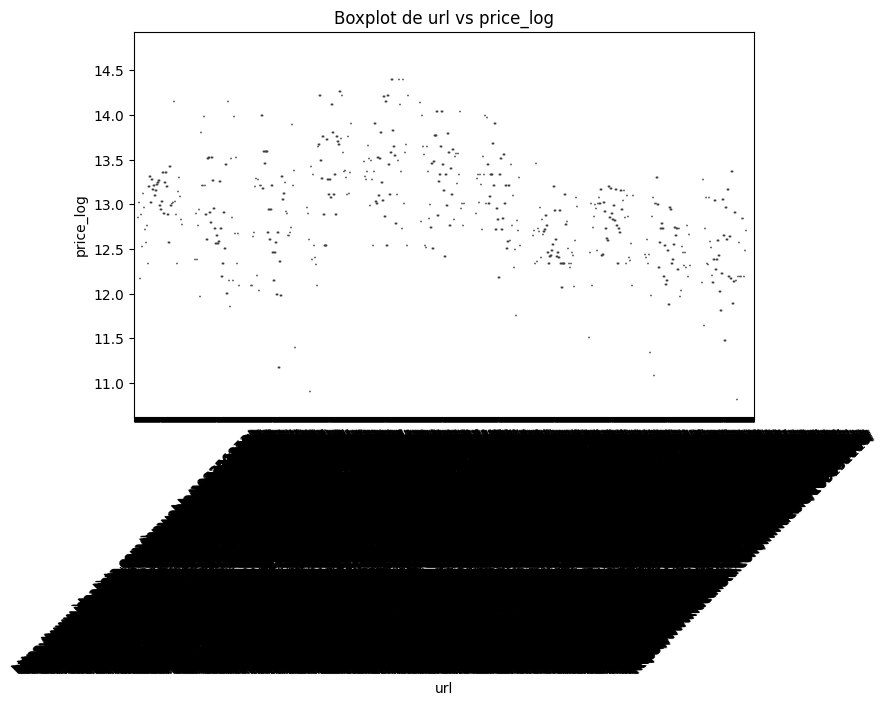

ANOVA url vs price_log: F=nan, p=nan


C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_26860\3488007448.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


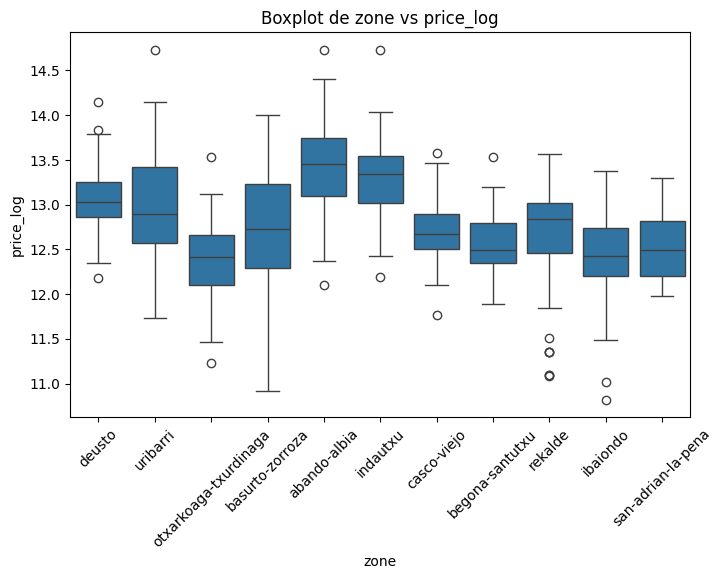

ANOVA zone vs price_log: F=69.90, p=0.0000


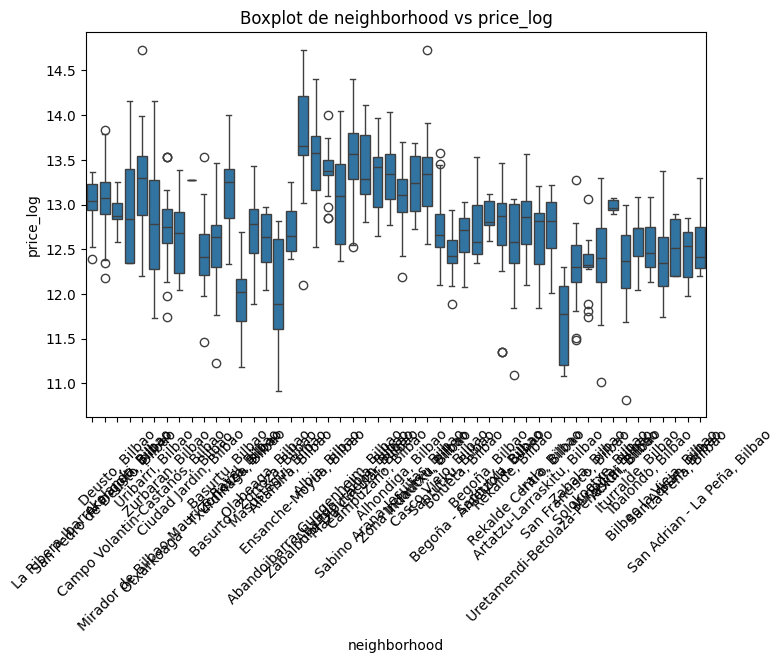

ANOVA neighborhood vs price_log: F=25.86, p=0.0000


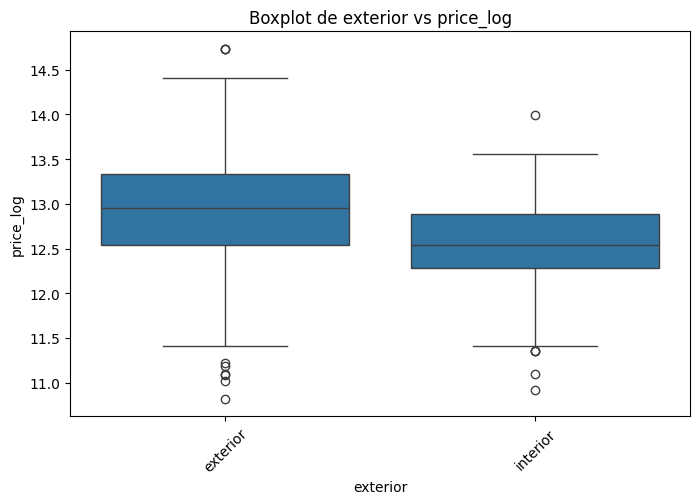

ANOVA exterior vs price_log: F=70.22, p=0.0000


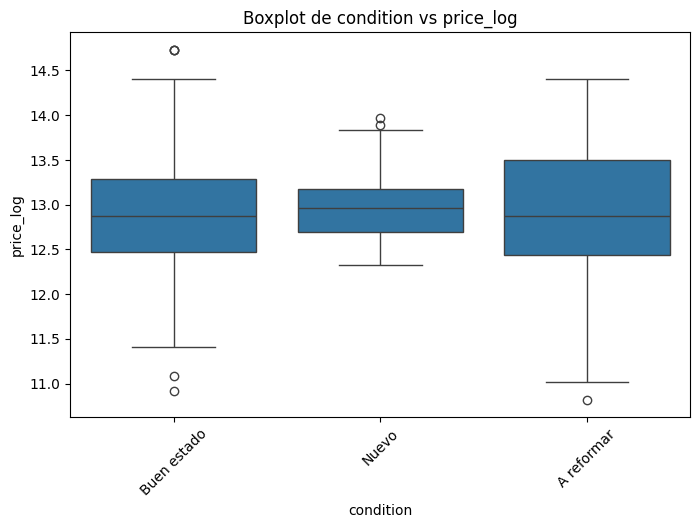

ANOVA condition vs price_log: F=0.92, p=0.3978


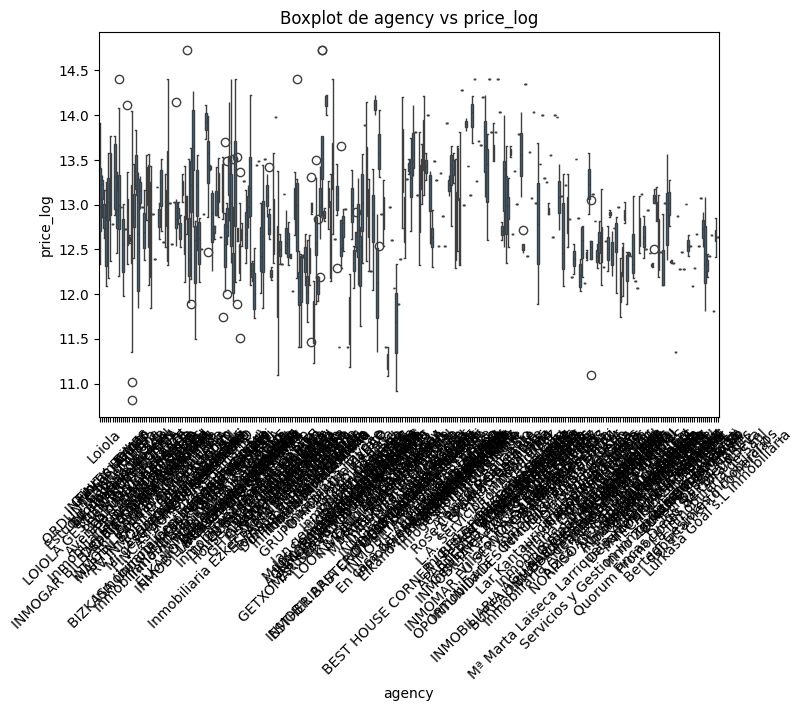

ANOVA agency vs price_log: F=3.24, p=0.0000


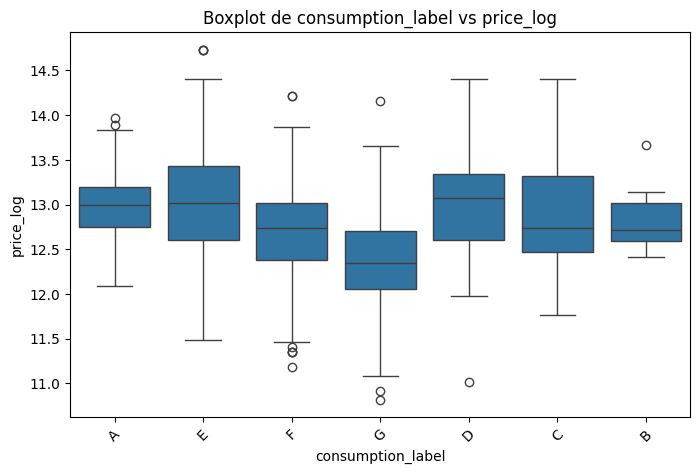

ANOVA consumption_label vs price_log: F=42.63, p=0.0000


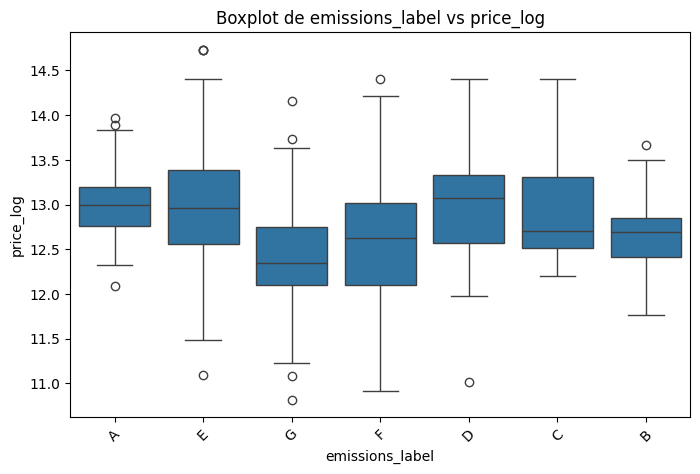

ANOVA emissions_label vs price_log: F=22.77, p=0.0000
DETECT NON LINEARITY------------------------------------


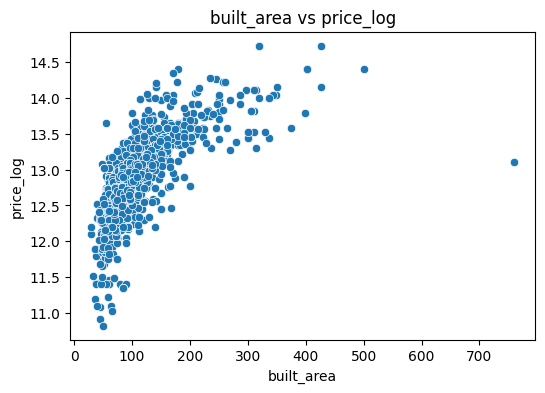

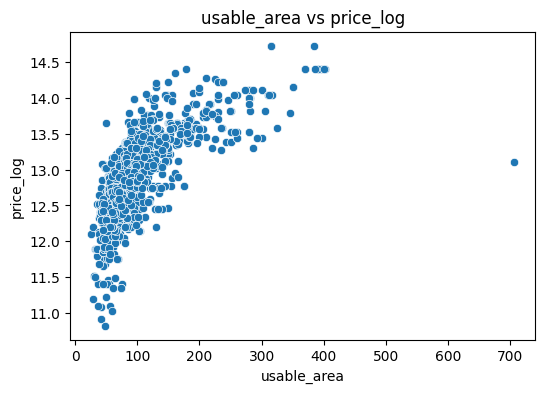

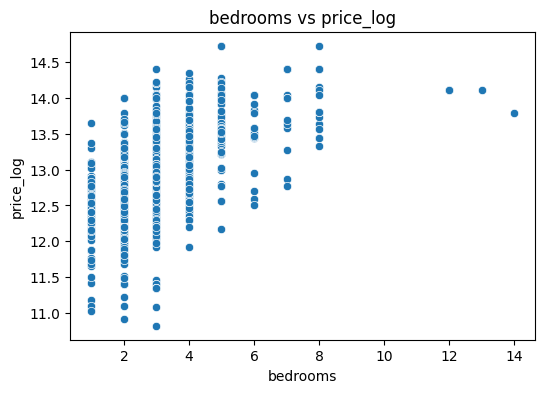

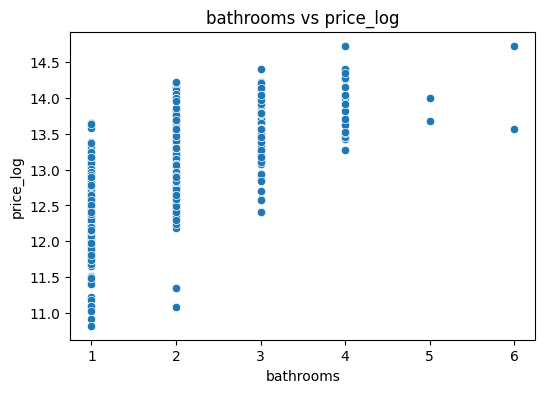

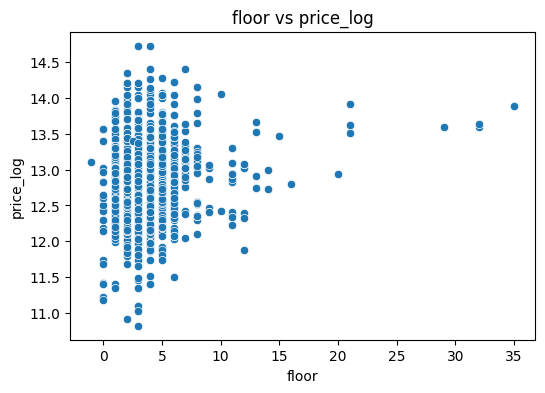

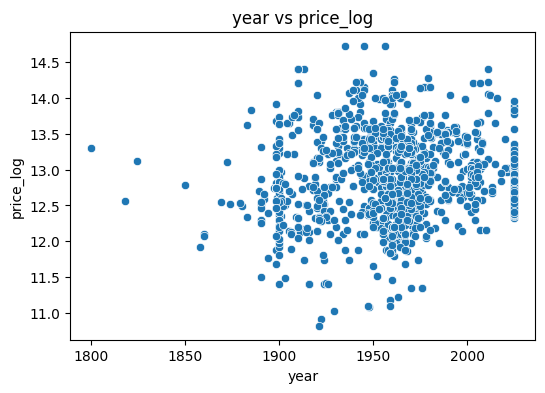

In [ ]:

dataCpy['price_log'] = np.log1p(dataCpy['price'])

plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price_log'], bins=50, kde=True)
plt.title("Distribución log-transformada del target")
plt.show()
print("\nSkew:", dataCpy['price_log'].skew())
print("Kurtosis:", dataCpy['price_log'].kurtosis())




print("BIVARIATE------------------------------------")

corr = dataCpy[numerical_features + ['price_log']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y price_log(target)")
plt.show()

# categorical features vs target
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price_log")
    plt.xticks(rotation=45)
    plt.show()

    # ANOVA (opcional)
    categories = dataCpy[col].dropna().unique()
    groups = [dataCpy[dataCpy[col]==cat]['price_log'] for cat in categories]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA {col} vs price_log: F={f_val:.2f}, p={p_val:.4f}")

print("DETECT NON LINEARITY------------------------------------")

# Scatterplots features vs target (numerical)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()



The results have improved: 
- less potential outliers: previously in the boxplots of zone vs price, there were potential outliers in uribarri, abando and indautxu. In year vs price around 1950 there were also 3 possible outliers.
- We gained a little bit of linearity in floor vs price relation. 
- There is still not linearity between year and price, this means that "year" is not directly proportionl with price.

However we lost a little bit of linearity (now has kind of logaritmic shape) in usable_area vs price and in built_area vs price; as well as in bedrooms and bathrooms so we will also transform usable_area and built_area to get that previous linearity. 

In [23]:
dataCpy.columns

Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'agency',
       'consumption_label', 'emissions_label', 'description', 'price_log'],
      dtype='object')

However there are some outliers in the neighbourhood vs price_log

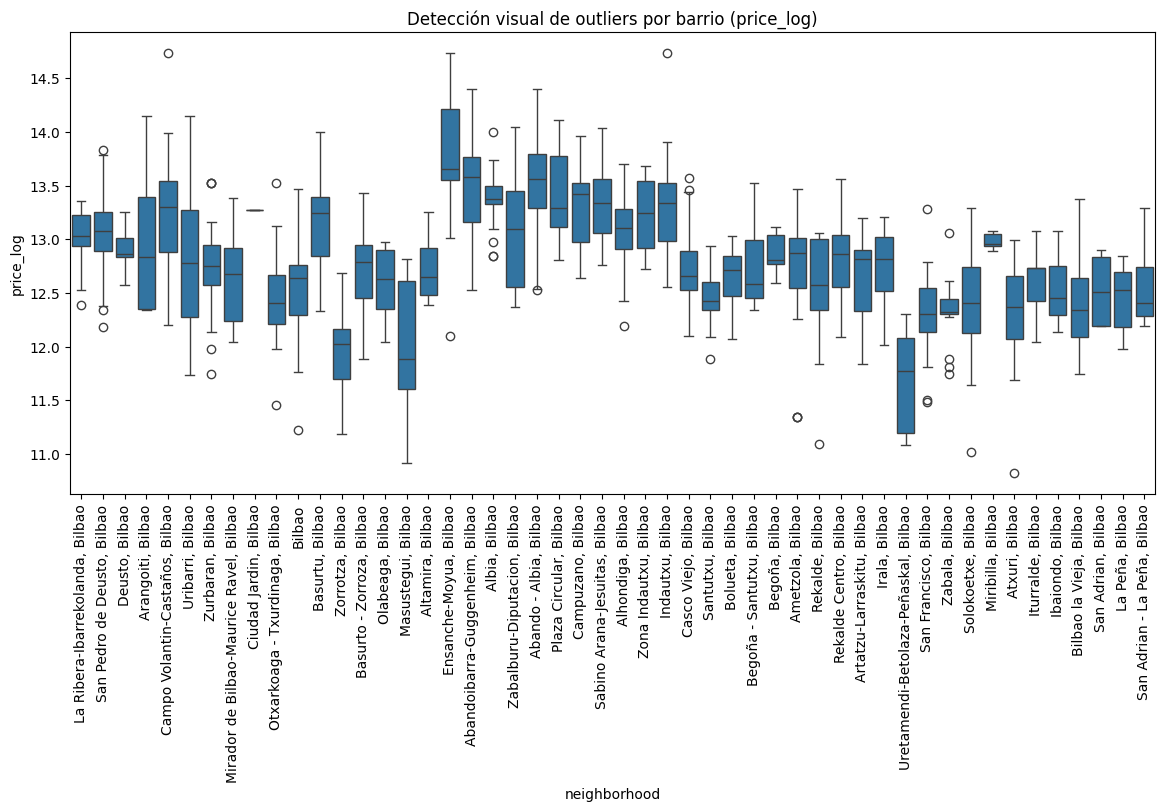

Outliers detectados: 37


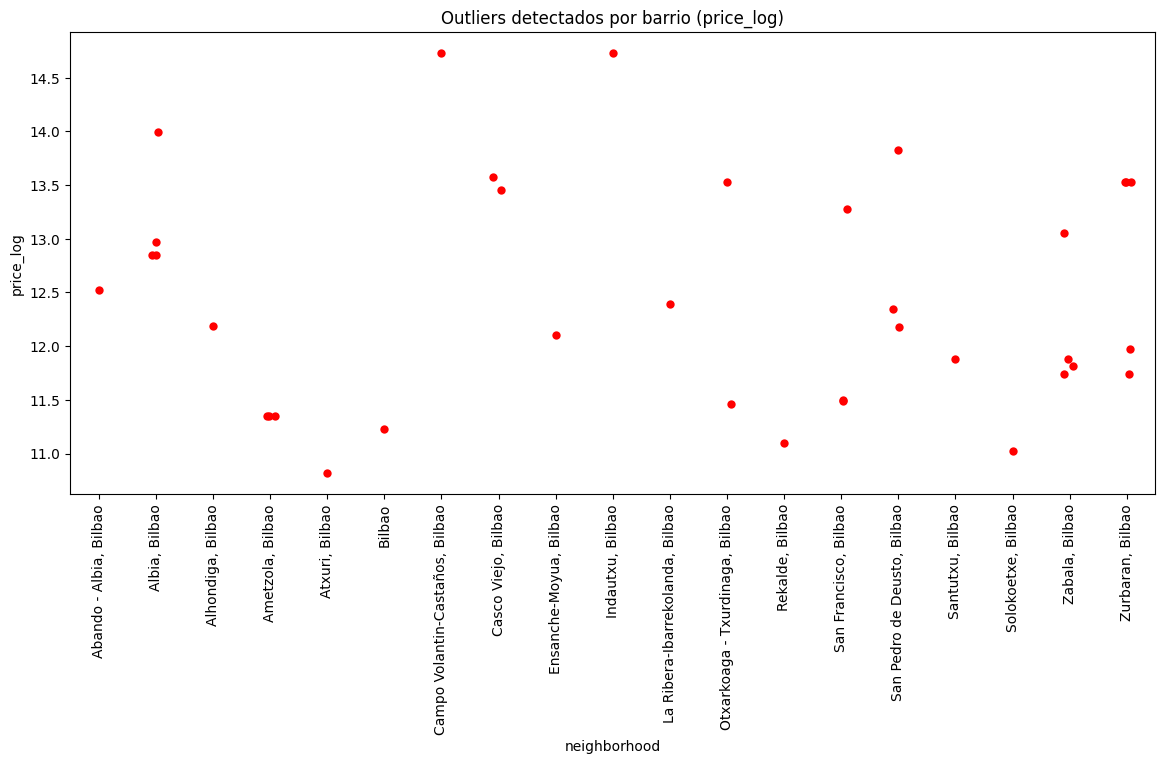

https://www.idealista.com/inmueble/107624252/  275001.00  Abando - Albia, Bilbao
https://www.idealista.com/inmueble/109360536/  430001.00  Albia, Bilbao
https://www.idealista.com/inmueble/107252250/  380001.00  Albia, Bilbao
https://www.idealista.com/inmueble/98413651/  380001.00  Albia, Bilbao
https://www.idealista.com/inmueble/106973182/  1200001.00  Albia, Bilbao
https://www.idealista.com/inmueble/108897414/  197001.00  Alhondiga, Bilbao
https://www.idealista.com/inmueble/107623208/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/105848587/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/35483234/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/108863561/  50001.00  Atxuri, Bilbao
https://www.idealista.com/inmueble/107608811/  75001.00  Bilbao
https://www.idealista.com/inmueble/105222282/  2500001.00  Campo Volantin-Castaños, Bilbao
https://www.idealista.com/inmueble/100817168/  785001.00  Casco Viejo, Bilbao
https://www.idealista.com/inm

In [ ]:

df = dataCpy.copy()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="neighborhood", y="price_log")
plt.xticks(rotation=90)
plt.title("Detección visual de outliers por barrio (price_log)")
plt.show()


outliers_list = []

for nb, group in df.groupby("neighborhood"):
    Q1 = group["price_log"].quantile(0.25)
    Q3 = group["price_log"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group["price_log"] < lower_bound) | (group["price_log"] > upper_bound)]
    outliers_list.append(outliers)

outliers_df = pd.concat(outliers_list)
print("Outliers detectados:", outliers_df.shape[0])
outliers_df.head()

# Detect outliers by neighborhood using IQR
outliers_list = []

for nb, group in df.groupby("neighborhood"):
    Q1 = group["price_log"].quantile(0.25)
    Q3 = group["price_log"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group["price_log"] < lower_bound) | (group["price_log"] > upper_bound)]
    outliers_list.append(outliers)

outliers_df = pd.concat(outliers_list)

# Plot only outliers
plt.figure(figsize=(14, 6))
sns.stripplot(data=outliers_df, x="neighborhood", y="price_log", color='red', size=6, jitter=True)
plt.xticks(rotation=90)
plt.title("Outliers detectados por barrio (price_log)")
plt.show()


# Rows of dataCpy (only of the detected ouliers)
outliers_rows = dataCpy.loc[outliers_df.index]

# Show first rows
for idx, row in outliers_rows.iterrows():
    print(f"{row['url']}  {np.exp(row['price_log']):.2f}  {row['neighborhood']}")

# Delete outliers de dataCpy (improves the results)
dataCpy_clean = dataCpy.drop(outliers_df.index).reset_index(drop=True)

print(f"Filas originales: {dataCpy.shape[0]}")
print(f"Filas después de eliminar outliers: {dataCpy_clean.shape[0]}")



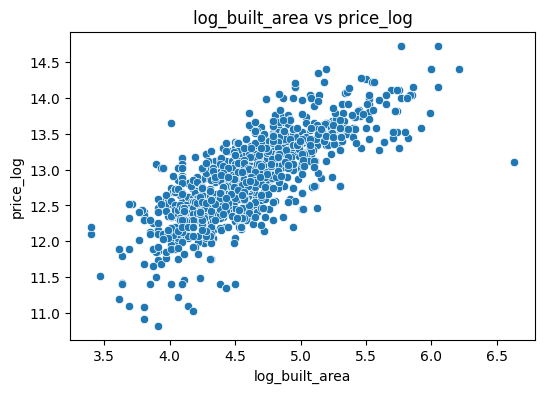

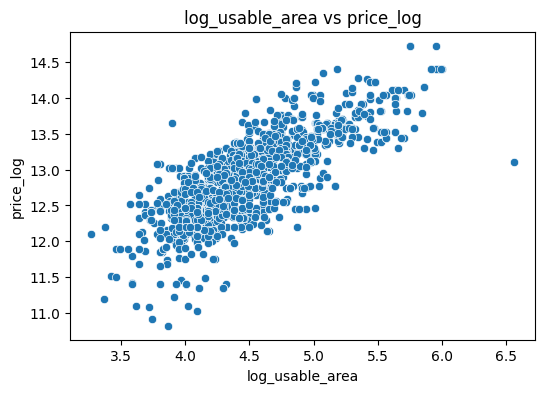

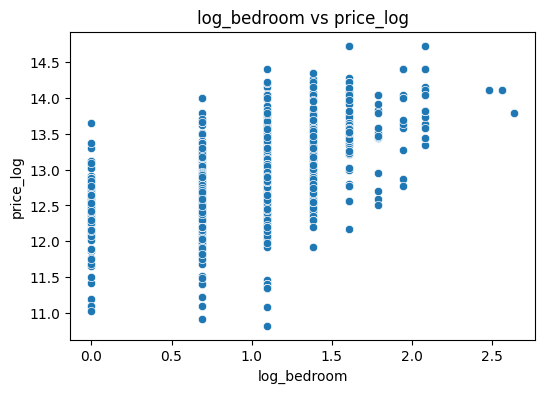

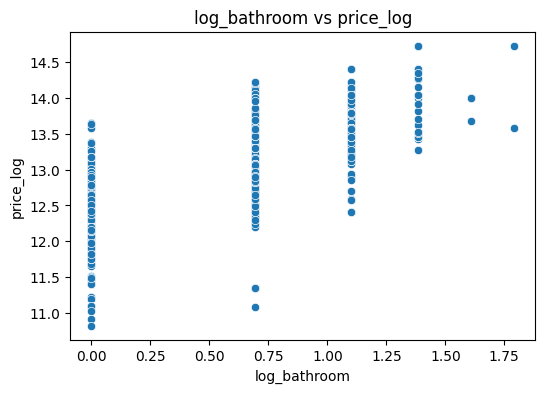

In [25]:
dataCpy["log_built_area"] = np.log(dataCpy["built_area"])
dataCpy["log_usable_area"] = np.log(dataCpy["usable_area"])
dataCpy["log_bedroom"] = np.log(dataCpy["bedrooms"])
dataCpy["log_bathroom"] = np.log(dataCpy["bathrooms"])



for col in ["log_built_area","log_usable_area","log_bedroom","log_bathroom"]:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()

#We have get that linearity again, PERFECT

The 3 potential outliers in bedroom vs price disappear with this trasnformation

We will check potential leverage in usable and built area vs price

                                              url     price  \
226  https://www.idealista.com/inmueble/97461275/  490000.0   

                      zone                     neighborhood  built_area  \
226  otxarkoaga-txurdinaga  Otxarkoaga - Txurdinaga, Bilbao       760.0   

     usable_area  bedrooms  bathrooms  floor  exterior  ...    year  \
226    706.01284         3          1   -1.0  interior  ...  1971.0   

                    agency  consumption_label  emissions_label  \
226  tomasa nuñez cañibano                  G                E   

                                           description  price_log  \
226  Caserio para reforma total de 760m2 repartidos...  13.102163   

     log_built_area log_usable_area log_bedroom log_bathroom  
226        6.633318        6.559633    1.098612          0.0  

[1 rows x 26 columns]


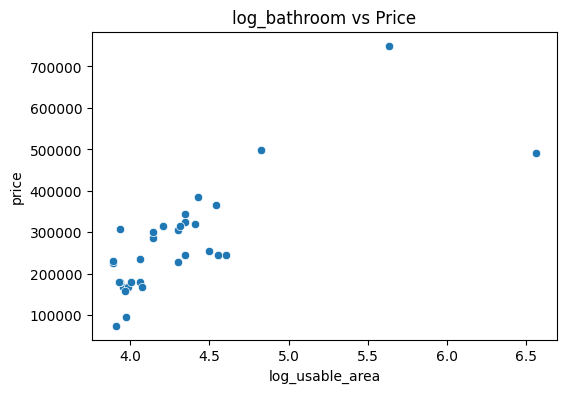

                                               url     price  \
211  https://www.idealista.com/inmueble/104990963/  750000.0   

                      zone                     neighborhood  built_area  \
211  otxarkoaga-txurdinaga  Otxarkoaga - Txurdinaga, Bilbao       301.0   

     usable_area  bedrooms  bathrooms  floor  exterior  ...    year  \
211        280.0         5          4    5.0  exterior  ...  1990.0   

                      agency  consumption_label  emissions_label  \
211  jose miguel ruiz garcia                  E                E   

                                           description price_log  \
211  API DIPUTACION, 4 HABITALE, VENDE MAGNIFICO DU...  13.52783   

     log_built_area log_usable_area log_bedroom log_bathroom  
211         5.70711         5.63479    1.609438     1.386294  

[1 rows x 26 columns]
url                      https://www.idealista.com/inmueble/104990963/
price                                                         750000.0
zone        

In [ ]:
#We print the house
print(dataCpy.loc[dataCpy["usable_area"]>=700])
#As we can see in the plot house in otxarkoaga-txurdinaga, with 700m2 of usable area is cleary a leverage point, so we will delete it from our data_regresion
data=dataCpy.loc[dataCpy["zone"]=="otxarkoaga-txurdinaga"]
dataCpy

plt.figure(figsize=(6,4))
sns.scatterplot(x=dataCpy["log_usable_area"], y='price', data=data)
plt.title(f"{col} vs Price")
plt.show()

#we delete it
dataCpy = dataCpy.drop(index=226)
#print(dataCpy.loc[226])  # gives error: correctly deleted


#Moreover the house with a price of more than 700k euros, is not from otxarkoaga-txurdinaga, but from Zurbaran (this may have been an error in scrapping), so we will change it to what it says in the web:
#Zone: uribarri
#neighbourhoof: Zurbaran, Bilbao
print(dataCpy.loc[(dataCpy["price"] >= 700000) & (dataCpy["zone"] == "otxarkoaga-txurdinaga")])

dataCpy.loc[211, "zone"] = "uribarri"
dataCpy.loc[211, "neighborhood"] = "Zurbaran, Bilbao"


print(dataCpy.loc[211])


# 4) Simple linear regression


Now we will try two linear regression models, 1 with and another without the transformations we made above, so that we can see how those transformations improved the model: 


In [27]:
#3.We will get the features which the model will be working with (initally)
print(f"All features: {dataCpy.columns}\n\n")


All features: Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'agency',
       'consumption_label', 'emissions_label', 'description', 'price_log',
       'log_built_area', 'log_usable_area', 'log_bedroom', 'log_bathroom'],
      dtype='object')




In [28]:

#target (with transformation)
target_price_transf = dataCpy.price_log

#target (with NO transformation)
target_price_no_transf = dataCpy.price


#For training the model will not take into account: Url, price, price_log (is the target), description and agency.
data_regresion = dataCpy.drop(["url","price","price_log", "description", "agency"], axis=1)

print(f"Initially selected features for model with transformations: {data_regresion.columns}")
#We deleted description feature, since the goal of the model is to predict or tell and announcment price with objective data of your house.
#We deleted the agency because of the same reason.


#1.We will check if there are missing values in the features we will be using(there should not be any, since we have previously done data cleaning)
print(f"Missing values:\n{data_regresion.isnull().sum()}") #0 missing values in target PERFECT



Initially selected features for model with transformations: Index(['zone', 'neighborhood', 'built_area', 'usable_area', 'bedrooms',
       'bathrooms', 'floor', 'exterior', 'elevator', 'garage', 'storage_room',
       'balcony', 'new', 'condition', 'year', 'consumption_label',
       'emissions_label', 'log_built_area', 'log_usable_area', 'log_bedroom',
       'log_bathroom'],
      dtype='object')
Missing values:
zone                 0
neighborhood         0
built_area           0
usable_area          0
bedrooms             0
bathrooms            0
floor                0
exterior             0
elevator             0
garage               0
storage_room         0
balcony              0
new                  0
condition            0
year                 0
consumption_label    0
emissions_label      0
log_built_area       0
log_usable_area      0
log_bedroom          0
log_bathroom         0
dtype: int64


In [29]:
# Convert to binary
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new', 'exterior']

binary_map = {
    True: 1, False: 0, 
    'True': 1, 'False': 0, 
    'Nuevo': 1, 'Buen estado': 0, 
    'exterior': 1, 'interior': 0
}

for col in binary_cols:
    data_regresion[col] = data_regresion[col].map(binary_map)

# Create Dummies
categorical_cols = ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label']
data_regresion = pd.get_dummies(data_regresion, columns=categorical_cols, drop_first=True)




print(data_regresion.shape)
#print(data_regresion.head())
num_filas_nan = data_regresion.isna().any(axis=1).sum()
print("Rows with NAN:", num_filas_nan) #0 rows with Nan (perfect)


(1228, 89)
Rows with NAN: 0


In [30]:
#we do not select the log transformed features for the model with no transformations
data_regresion_no_transformed = data_regresion.drop(["log_built_area","log_usable_area","log_bathroom","log_bedroom"], axis=1)

print(f"Initially selected features for model with no transformations: {data_regresion_no_transformed.columns}")

#we select the log transformed features for the model with  transformations
data_regresion_transformed = data_regresion.drop(["built_area","usable_area","bathrooms","bedrooms"], axis=1)

print(f"Initially selected features for model with transformations: {data_regresion_transformed.columns}")
#We deleted description feature, since the goal of the model is to predict or tell and announcment price with objective data of your house.
#We deleted the agency because of the same reason.

Initially selected features for model with no transformations: Index(['built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor',
       'exterior', 'elevator', 'garage', 'storage_room', 'balcony', 'new',
       'year', 'zone_basurto-zorroza', 'zone_begona-santutxu',
       'zone_casco-viejo', 'zone_deusto', 'zone_ibaiondo', 'zone_indautxu',
       'zone_otxarkoaga-txurdinaga', 'zone_rekalde', 'zone_san-adrian-la-pena',
       'zone_uribarri', 'neighborhood_Abandoibarra-Guggenheim, Bilbao',
       'neighborhood_Albia, Bilbao', 'neighborhood_Alhondiga, Bilbao',
       'neighborhood_Altamira, Bilbao', 'neighborhood_Ametzola, Bilbao',
       'neighborhood_Arangoiti, Bilbao',
       'neighborhood_Artatzu-Larraskitu, Bilbao',
       'neighborhood_Atxuri, Bilbao', 'neighborhood_Basurto - Zorroza, Bilbao',
       'neighborhood_Basurtu, Bilbao',
       'neighborhood_Begoña - Santutxu, Bilbao', 'neighborhood_Begoña, Bilbao',
       'neighborhood_Bilbao', 'neighborhood_Bilbao la Vieja, Bilbao

## Linear Regression without previous transformations

In [ ]:

X = data_regresion_no_transformed
y = target_price_no_transf


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


model = LinearRegression()

#We apply cross validation (eventhough this is not helpful for selecting hyperparameters; since we do not have hyperparameters in simple linear regression, it will help us to detect overfitting or underfittin)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(model, X_train, y_train, cv=kf)


cv_mae = mean_absolute_error(y_train, y_pred)
cv_r2 = r2_score(y_train, y_pred)

print("TRAIN: ")
print("CV MAE: %.2f €" % cv_mae)
print("CV R²: %.3f" % cv_r2)
mape = mean_absolute_percentage_error(y_train, y_pred)*100
print("Percentage MAPE CV: %.2f%%\n\n" % (mape))




TRAIN: 
CV MAE: 82786.35 €
CV R²: 0.834
Percentage MAPE CV: 20.99%




'\nmodel.fit(X_train, y_train)\n\n#We finally evaluate the model with test\ny_pred = model.predict(X_test)\n\n\n\nmae_test = mean_absolute_error(y_test, y_pred)\nr2_test = r2_score(y_test, y_pred)\n\nprint("TEST: ")\nprint("Test MAE: %.2f €" % mae_test)\nprint("Test R²: %.3f" % r2_test)\nmape = mean_absolute_percentage_error(y_test, y_pred)*100\nprint("Percentage MAPE CV: %.2f%%\n\n" % (mape))\n'

### Underfitting/Overfitting evaluation: 

- there is NOT underfitting: R2 is both high in train and test and MAE are both more or less the same, a little high however. 
- there is NOT overfitting: the difference between R2 and MAE in train and test is not big enough.

Conclusion: no underfitting nor overfitting but the model is not good enough (20.99% of MAE is high)

## Linear Regression with previous transformations

In [ ]:


X = data_regresion_transformed
y = target_price_transf


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


model = LinearRegression()

#We apply cross validation (eventhough this is not helpful for selecting hyperparameters; since we do not have hyperparameters in simple linear regression, it will help us to detect overfitting or underfittin)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_log = cross_val_predict(model, X_train, y_train, cv=kf)

#Since in EDA we transformed the target price to logaritmic, we now transform it again to original units so that we can interpret the metrics
y_pred_cv = np.exp(y_pred_cv_log)
y_true_cv = np.exp(y_train)

cv_mae = mean_absolute_error(y_true_cv, y_pred_cv)
cv_r2 = r2_score(y_true_cv, y_pred_cv)

print("CV MAE: %.2f €" % cv_mae)
print("CV R²: %.3f" % cv_r2)
mape = mean_absolute_percentage_error(y_true_cv, y_pred_cv)*100  # 0.12
print("Percentage MAPE CV: %.2f%%\n\n" % (mape))
model.fit(X_train, y_train)



CV MAE: 73854.21 €
CV R²: 0.858
Percentage MAPE CV: 17.21%




'\n#We finally evaluate the model with test\ny_pred_log = model.predict(X_test)\n\n#Again, since in EDA we transformed the target price to logaritmic, we now transform it again to original units so that we can interpret the metrics\ny_pred = np.exp(y_pred_log)\ny_test_euros = np.exp(y_test)\n\nmae_test = mean_absolute_error(y_test_euros, y_pred)\nr2_test = r2_score(y_test_euros, y_pred)\n\nprint("Test MAE: %.2f €" % mae_test)\nprint("Test R²: %.3f" % r2_test)\n\n\nmape = mean_absolute_percentage_error(y_test_euros, y_pred) *100 \nprint("Percentage MAPE CV: %.2f%%\n\n" % (mape))\n'

### Underfitting/Overfitting evaluation: 

- there is NOT underfitting: R2 is both high in train and test and MAE are both more or less the same, a little high however. 
- there is NOT overfitting: the difference between R2 and MAE in train and test is not big enough.

Conclusion: no underfitting nor overfitting and the model is better than the one without transformations, but it is still not good enough (17.21% of MAE is still high)

##### As we can see the log transformation improved the simple linear regression model, however we will now try with regularization methods and more complex models to try to improve even more the results

# 5) Regularization methods



- These methods are good for controlling the overfitting, however we do not have problematic overfitting in our simple linear regression with transformation, so they may not give much better results


### We first define the evaluation functions for optuna

In [33]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = data_regresion_transformed
y = target_price_transf  # log-transformado

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Evaluation functions for optuna (we want optuna to minimize the relative mae)
def objective_lasso(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, fit_intercept=fit_intercept)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)

    
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    r2 = r2_score(y_true, y_pred)

    trial.set_user_attr("r2_cv", r2)

    return mape

def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'])
    
    model = Ridge(alpha=alpha, max_iter=max_iter, tol=tol, fit_intercept=fit_intercept, solver=solver)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    r2 = r2_score(y_true, y_pred)

    trial.set_user_attr("r2_cv", r2)
    return mape

def objective_elasticnet(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    selection = trial.suggest_categorical('selection', ['cyclic','random'])
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol,
                       fit_intercept=fit_intercept, selection=selection)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    r2 = r2_score(y_true, y_pred)

    trial.set_user_attr("r2_cv", r2)
    return mape



### Optuna for the hyperparameters

In [34]:

#We use "minimize" because we want optuna to minimze the relative mae
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=50)

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=50)

study_en = optuna.create_study(direction='minimize')
study_en.optimize(objective_elasticnet, n_trials=50)



[I 2025-11-28 18:58:49,923] A new study created in memory with name: no-name-96aa0bf7-65b5-4391-9789-805c28ef84a2
C:\Users\david.r\AppData\Local\Temp\ipykernel_26860\4235188319.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
C:\Users\david.r\AppData\Local\Temp\ipykernel_26860\4235188319.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
[I 2025-11-28 18:58:49,952] Trial 0 finished with value: 99.99973298281542 and parameters: {'alpha': 0.34394960288490034, 'max_iter': 3000, 'tol': 0.0019405527255692183, 'fit_intercept': False}. Best is trial 0 with value: 99.99

### From now on for evaluating the models we will be using this function

### Evaluate the best models (the ones with the best hyperparameters selected by Optuna)


In [ ]:
#** is for despackaging a dictionary

best_lasso = Lasso(**study_lasso.best_params)
best_lasso.fit(X_train, y_train)
best_ridge = Ridge(**study_ridge.best_params)
best_ridge.fit(X_train, y_train)
best_en = ElasticNet(**study_en.best_params)
best_en.fit(X_train, y_train)

print("Lasso CV MAPE:", study_lasso.best_value)
print("Lasso CV R2:", study_lasso.best_trial.user_attrs["r2_cv"],"\n")

print("Ridge CV MAPE:", study_ridge.best_value)
print("Ridge CV R2:", study_ridge.best_trial.user_attrs["r2_cv"],"\n")

print("Elastic CV MAPE:", study_en.best_value)
print("Elastic CV R2:", study_en.best_trial.user_attrs["r2_cv"],"\n")


Lasso CV MAPE: 17.037922106488647
Lasso CV R2: 0.8549932357904435 

Ridge CV MAPE: 17.037404845984927
Ridge CV R2: 0.8580702927318968 

Elastic CV MAPE: 17.010793490701456
Elastic CV R2: 0.8561933395718173 



'\nmetrics_lasso = evaluate_model(best_lasso, X_train, X_test, y_train, y_test)\nmetrics_ridge = evaluate_model(best_ridge, X_train, X_test, y_train, y_test)\nmetrics_en = evaluate_model(best_en, X_train, X_test, y_train, y_test)\n\n# ---------- LASSO ----------\nprint("LASSO Train:")\nprint(f"R2 = {metrics_lasso[\'train\'][\'R2\']:.3f}")\nprint(f"MAE = {metrics_lasso[\'train\'][\'MAE\']:.2f} €")\nprint(f"MAPE = {metrics_lasso[\'train\'][\'MAPE\']:.2f}%\n")\n\nprint("LASSO Test:")\nprint(f"R2 = {metrics_lasso[\'test\'][\'R2\']:.3f}")\nprint(f"MAE = {metrics_lasso[\'test\'][\'MAE\']:.2f} €")\nprint(f"MAPE = {metrics_lasso[\'test\'][\'MAPE\']:.2f}%\n")\n\n\n# ---------- RIDGE ----------\nprint("RIDGE Train:")\nprint(f"R2 = {metrics_ridge[\'train\'][\'R2\']:.3f}")\nprint(f"MAE = {metrics_ridge[\'train\'][\'MAE\']:.2f} €")\nprint(f"MAPE = {metrics_ridge[\'train\'][\'MAPE\']:.2f}%\n")\n\nprint("RIDGE Test:")\nprint(f"R2 = {metrics_ridge[\'test\'][\'R2\']:.3f}")\nprint(f"MAE = {metrics_ridge

### Evaluation of underfitting or overfitting

Overall in the 3 models...: 
- there is NOT underfitting: R2 are both high in train and test and MAE are both more or less the same and not to high. 
- there is NOT problematic overfitting: it is true that there is a difference between R2 and MAPE but no so big to consider it as problematic.


### Until NOW.....

The best model is achieved applying Elastic Net regularization, 
LASSO Test:
- Elastic CV MAPE: 17.022628311850667
- Elastic CV R2: 0.8560219895539117 

Simple Linear regression with transformations
- CV R²: 0.858
- Percentage MAPE CV: 17.21%

# 6) More Complex Models

In [36]:
import re

X = data_regresion_transformed.copy()

# replace characters that are not a-z, A-Z, 0-9 o _
X.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in X.columns]


In [37]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # ---- TRAIN ----
    y_train_pred_log = model.predict(X_train)
    y_train_pred = np.exp(y_train_pred_log)
    y_train_true = np.exp(y_train)

    mae_train = mean_absolute_error(y_train_true, y_train_pred)
    r2_train = r2_score(y_train_true, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_true, y_train_pred)*100

    # ---- Validation ----
    y_test_pred_log = model.predict(X_test)
    y_test_pred = np.exp(y_test_pred_log)
    y_test_true = np.exp(y_test)

    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_true, y_test_pred)*100


    return {
        "train": {
            "MAE": mae_train,
            "R2": r2_train,
            "MAPE": mape_train
        },
        "Validation": {
            "MAE": mae_test,
            "R2": r2_test,
            "MAPE": mape_test
        }
    }


In [ ]:
def evaluate_fold(y_true, y_pred): #calculate metrics of only one fold
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {"MAE": mae, "R2": r2, "MAPE": mape}

In [ ]:
def train_and_evaluate(model, name, X, y, cat_features=None, n_splits=5, test_size=0.2, random_state=42):

    # --- Step 0: Split train/test ---
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale only if necessary
    if name in ["RANSAC","TheilSen","HuberRegressor","SVR"]:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_full)
        X_train_use = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_full.index)
        X_test_scaled = scaler.transform(X_test)
        X_test_use = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    else:
        X_train_use = X_train_full.copy()
        X_test_use = X_test.copy()

    # --- Step 1: K-Fold CV only with train---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    val_results = []

    print(f"\n======================================")
    print(f"Cross Validation: {name} ({n_splits}-fold)")
    print("======================================")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_use)):
        X_train_fold = X_train_use.iloc[train_idx]
        y_train_fold = y_train_full.iloc[train_idx]
        X_val_fold = X_train_use.iloc[val_idx]
        y_val_fold = y_train_full.iloc[val_idx]

        # train
        if name == "CatBoost":
            model.fit(X_train_fold, y_train_fold, cat_features=cat_features, verbose=0)
        else:
            model.fit(X_train_fold, y_train_fold)

        # validation
        y_val_pred_log = model.predict(X_val_fold)
        y_val_pred = np.exp(y_val_pred_log)  
        y_val_true = np.exp(y_val_fold)

        val_results.append(evaluate_fold(y_val_true, y_val_pred))
        print(f"Fold {fold+1}: {val_results[-1]}")

    # Mean validation metrics
    avg_val = {
        "MAE": np.mean([r["MAE"] for r in val_results]),
        "R2": np.mean([r["R2"] for r in val_results]),
        "MAPE": np.mean([r["MAPE"] for r in val_results])
    }

    print("\nAVG Validation metrics (CV folds):", avg_val)
    return avg_val, (X_train_use, X_test_use, y_train_full, y_test)

In [ ]:
# ================================================
#   MODELS WITH 100% DEFAULT HYPERPARAMETERS
# ================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


X = data_regresion_transformed.copy()
y = target_price_transf

# Security measure for LightGBM y XGBoost
X.columns = [col.replace(" ", "_")
                .replace("-", "_")
                .replace("+", "plus")
                .replace(".", "_")
                .replace("(", "_")
                .replace(")", "_")
             for col in X.columns]

# dummies for catboost
cat_features = [X.columns.get_loc(col) for col in ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label'] if col in X.columns]

# ===========================================================
# 1) RANSAC
# ===========================================================
model_ransac = RANSACRegressor()
results_ransac = train_and_evaluate(model_ransac, "RANSAC", X, y)

# ===========================================================
# 2) TheilSen
# ===========================================================
model_theilsen = TheilSenRegressor()
results_theilsen = train_and_evaluate(model_theilsen, "TheilSen", X, y)

# ===========================================================
# 3) Huber Regressor
# ===========================================================
model_huber = HuberRegressor()
results_huber = train_and_evaluate(model_huber, "HuberRegressor", X, y)

# ===========================================================
# 4) SVR
# ===========================================================
model_svr = SVR()
results_svr = train_and_evaluate(model_svr, "SVR", X, y)

# ===========================================================
# 5) RandomForestRegressor
# ===========================================================
model_rf = RandomForestRegressor()
results_rf = train_and_evaluate(model_rf, "RandomForestRegressor", X, y)

# ===========================================================
# 6) XGBoost
# ===========================================================
model_xgb = xgb.XGBRegressor()
results_xgb = train_and_evaluate(model_xgb, "XGBoost", X, y)


# ===========================================================
# 8) CatBoostRegressor
# ===========================================================
model_cat = CatBoostRegressor(verbose=False)
results_cat = train_and_evaluate(model_cat, "CatBoost", X, y, cat_features=cat_features)




Cross Validation: RANSAC (5-fold)
Fold 1: {'MAE': 68664.15610056682, 'R2': 0.902059954454872, 'MAPE': 16.48630846865002}
Fold 2: {'MAE': 94555.78236465844, 'R2': 0.8099710747322708, 'MAPE': 18.125719080011443}
Fold 3: {'MAE': 63005.95242570607, 'R2': 0.859312007309198, 'MAPE': 16.294996288372516}
Fold 4: {'MAE': 75883.369940312, 'R2': 0.8467996161762951, 'MAPE': 19.601654180676963}
Fold 5: {'MAE': 79821.34520721738, 'R2': 0.7999673834250687, 'MAPE': 20.62233802306694}

AVG Validation metrics (CV folds): {'MAE': np.float64(76386.12120769215), 'R2': np.float64(0.843622007219541), 'MAPE': np.float64(18.226203208155574)}

Cross Validation: TheilSen (5-fold)
Fold 1: {'MAE': 308232.81357033004, 'R2': -0.6335130087207863, 'MAPE': 69.57649549334268}
Fold 2: {'MAE': 291278.1292284889, 'R2': -0.22881771977824772, 'MAPE': 60.02409790077452}
Fold 3: {'MAE': 247126.99268434424, 'R2': -0.49790046633820806, 'MAPE': 61.54636309197994}
Fold 4: {'MAE': 268241.32545653987, 'R2': -0.33500500697383706, 'M

C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\david.r\AppDa

Fold 4: {'MAE': 70723.11188838075, 'R2': 0.8581799356460593, 'MAPE': 18.43887722173554}
Fold 5: {'MAE': 72145.08159565472, 'R2': 0.830102698202045, 'MAPE': 18.70132647366575}

AVG Validation metrics (CV folds): {'MAE': np.float64(72386.59665890221), 'R2': np.float64(0.8576063311898217), 'MAPE': np.float64(17.227773458794672)}

Cross Validation: SVR (5-fold)
Fold 1: {'MAE': 74505.0515050963, 'R2': 0.8237373416660451, 'MAPE': 17.148559731775315}
Fold 2: {'MAE': 99590.32557448673, 'R2': 0.7379934180316965, 'MAPE': 17.618650355726466}
Fold 3: {'MAE': 66839.37226330805, 'R2': 0.8528752039658756, 'MAPE': 16.979993008087717}
Fold 4: {'MAE': 72378.70650765888, 'R2': 0.8186629144137522, 'MAPE': 17.579334762688994}
Fold 5: {'MAE': 66412.13337302014, 'R2': 0.8574917706435912, 'MAPE': 18.213823080188913}

AVG Validation metrics (CV folds): {'MAE': np.float64(75945.11784471403), 'R2': np.float64(0.8181521297441922), 'MAPE': np.float64(17.508072187693482)}

Cross Validation: RandomForestRegressor (5

Names of X were given erros to LGB, we correct them: 

In [ ]:
import re

X = data_regresion_transformed.copy()

# Security measure for LightGBM (without this, gived erros)
X.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in X.columns]


In [42]:
# ===========================================================
# 7) LightGBM
# ===========================================================
model_lgb = lgb.LGBMRegressor()
results_lgb = train_and_evaluate(model_lgb, "LightGBM", X, y)


Cross Validation: LightGBM (5-fold)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 785, number of used features: 45
[LightGBM] [Info] Start training from score 12.890125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp


### The best results was achieved with Catboost: 
- AVG Validation metrics (CV folds): {'MAE': 68163.49839593444, 'R2': 0.8600934083546115, 'MAPE': 15.44516103871948}


### Better than the model with LASSO regularization: 

LASSO Test:
- Lasso CV MAPE: 17.036768660381547
- Lasso CV R2: 0.8546062696913334 

We will use optuna again to select the best hyperparameters for this model with the objective of improving (reducing) more the Relative MAE

In [ ]:
X = data_regresion_transformed
y = target_price_transf  

# categorical colums
categorical_cols = ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label']
cat_features = [i for i, col in enumerate(X.columns) if col in categorical_cols]

# Split without scaling (CatBoost manages categorical variables without scalling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 4, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.6, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'verbose': 0,
        'cat_features': cat_features, 
        'random_state': 42
    }
    
    # Manual Cross-validationfor CatBoost
    mape_scores = []
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
        
        # Predictions at log scale
        y_pred_log = model.predict(X_val)
        
        # Change to original scale
        y_pred = np.exp(y_pred_log)
        y_true = np.exp(y_val)
        
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        
        mape_scores.append(mape)
        r2_scores.append(r2)
    
    mean_mape = np.mean(mape_scores)
    mean_r2 = np.mean(r2_scores)
    
    trial.set_user_attr("r2_cv", mean_r2)
    trial.set_user_attr("mape_cv", mean_mape)
    
    return mean_mape

# Optuna
study = optuna.create_study(direction='minimize', study_name='CatBoost_Relative_MAE')
study.optimize(objective_catboost, n_trials=50, timeout=3600)

# See best hyperparameters
print("Mejores hiperparámetros:", study.best_params)
print(f"Mejor MAPE: {study.best_value:.2f}%")
print(f"R² con mejores params: {study.best_trial.user_attrs['r2_cv']:.4f}")



[I 2025-11-28 19:00:55,382] A new study created in memory with name: CatBoost_Relative_MAE
[I 2025-11-28 19:01:04,672] Trial 0 finished with value: 16.615926701179706 and parameters: {'iterations': 1102, 'depth': 6, 'learning_rate': 0.019049063417932187, 'l2_leaf_reg': 5.994309715389084, 'bagging_temperature': 0.8308531930647268, 'random_strength': 5.248935380673657, 'border_count': 159}. Best is trial 0 with value: 16.615926701179706.
[I 2025-11-28 19:01:10,825] Trial 1 finished with value: 17.715617073914096 and parameters: {'iterations': 1057, 'depth': 4, 'learning_rate': 0.024026579978194088, 'l2_leaf_reg': 16.707638552320997, 'bagging_temperature': 0.7507043739607988, 'random_strength': 2.0294553101307935, 'border_count': 192}. Best is trial 0 with value: 16.615926701179706.
[I 2025-11-28 19:01:19,665] Trial 2 finished with value: 17.703885801669962 and parameters: {'iterations': 1082, 'depth': 5, 'learning_rate': 0.019663706705326498, 'l2_leaf_reg': 14.876937711883075, 'bagging_t

Mejores hiperparámetros: {'iterations': 2758, 'depth': 6, 'learning_rate': 0.044010380173158184, 'l2_leaf_reg': 10.294977382298905, 'bagging_temperature': 0.6585683982576082, 'random_strength': 9.492417267227713, 'border_count': 164}
Mejor MAPE: 15.08%
R² con mejores params: 0.8646


'\n# Entrenar modelo final con mejores hiperparámetros\n\n'

### Results of applying optuna 

- Mejores hiperparámetros: {'iterations': 2758, 'depth': 6, 'learning_rate': 0.044010380173158184, 'l2_leaf_reg': 10.294977382298905, 'bagging_temperature': 0.6585683982576082, 'random_strength': 9.492417267227713, 'border_count': 164}
- Mejor MAPE: 15.08%
- R² con mejores params: 0.8646

### Which are better results than the ones achieved with the Catboost model that used default hyperparameters:

- MAPE: 15.45%
- R2: 0.8601



### Hyperparameter importance

In [44]:

optuna.visualization.plot_param_importances(study).show()

### This means that by far the metric that have more impact in the MAPE (the metric that optuna is trying to optimize), is the learning_rate.

- This metric controls how much the model adjusts (learns) at each boosting iteration, this is, the step the model takes when learning from each tree. High values means faster learning but with risk of overfitting, and Lower values means slower but safer training. 


# 7) Test with the final model

In [48]:
best_params = study.best_params
best_params['cat_features'] = cat_features
best_params['verbose'] = 0

final_model = CatBoostRegressor(**best_params)

final_model.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test), 
    early_stopping_rounds=50, 
    verbose=False
)

y_pred = np.exp(final_model.predict(X_test))
y_true = np.exp(y_test)

mape = mean_absolute_percentage_error(y_true, y_pred)*100
r2 = r2_score(y_true, y_pred)

print(f"Metrics in test for the final model:")
print(f"MAPE: {round(mape,2)}%")
print(f"R2: {round(r2,4)}")


Metrics in test for the final model:
MAPE: 15.7%
R2: 0.805


### Evaluating underfitting/overfitting of the final model

The metrics of the validation split vs the metrics in real test with this model were: 
-       validation    test
- MAPE: 15.08% -----  15.7%
- R²: 0.8646 -------  0.8005

As we can see there is not to much difference between the validation and test set: we achieved high values in R2 and similar and not to high values in MAPE. So we do not have underfitting or overfitting. Meaning that the model generalizes well (more or less low variance gap between both R2 and MAPE) and is not bad at all at terms of precision (15.7% of MAPE)


# 8) Interpretations of the final model

### Feature importance 
- Individual importance of each feature (does not reflect interactions)

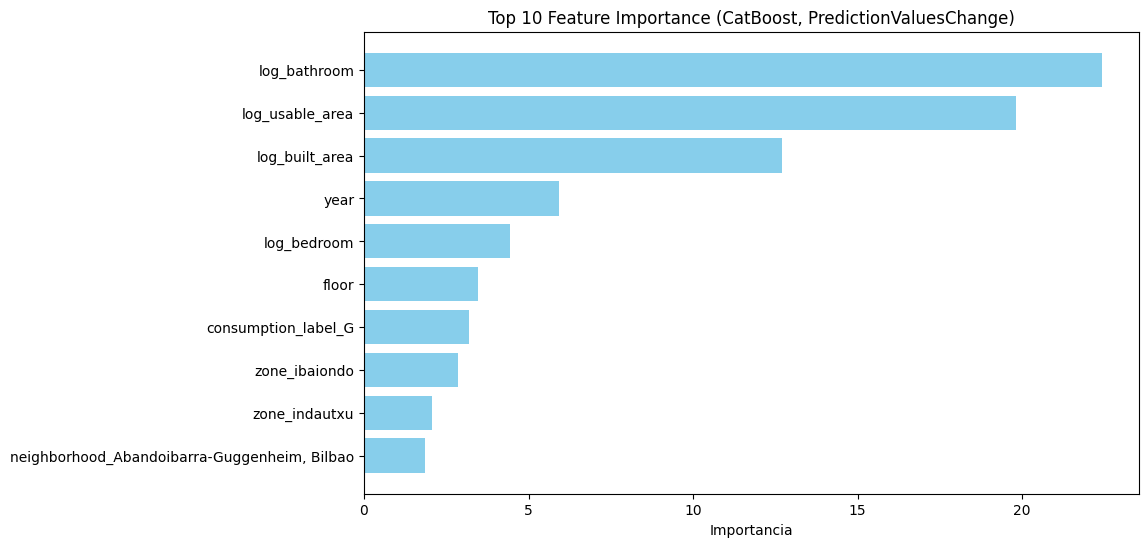

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance does not consider non linear interaction between features; only considers linear interactions. 
importances = final_model.get_feature_importance(type='PredictionValuesChange')
imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Only the top 10
top10 = imp_df.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10['feature'], top10['importance'], color='skyblue')
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Top 10 Feature Importance (CatBoost, PredictionValuesChange)")
plt.xlabel("Importancia")
plt.show()



This means that the most significance variables or the variables with most impact in the model are the the number of bathrooms, the usable area and the built area of the house. Meaning that the model depends mainly on these features for estimating the house prices. In contrast, other features such as the year of construction have a much lower contribution in price prediction, suggesting that they play a minor role in the model's prediction.


### ALE for the final model

In [ ]:
from alibi.explainers import ALE, plot_ale 

Applying ALE to categorical features is problematic; as we can see in the plot of feature importance, the most important features are: built area, number of bathrooms, usabe area, the year and the floor; which are numeric features. So we will only interpret how changes on these numerical features impact the model's predictions. 

array([[<Axes: xlabel='log_built_area', ylabel='ALE'>,
        <Axes: xlabel='log_bathroom', ylabel='ALE'>,
        <Axes: xlabel='log_usable_area', ylabel='ALE'>],
       [<Axes: xlabel='year', ylabel='ALE'>,
        <Axes: xlabel='floor', ylabel='ALE'>,
        <Axes: xlabel='log_bedroom', ylabel='ALE'>]], dtype=object)

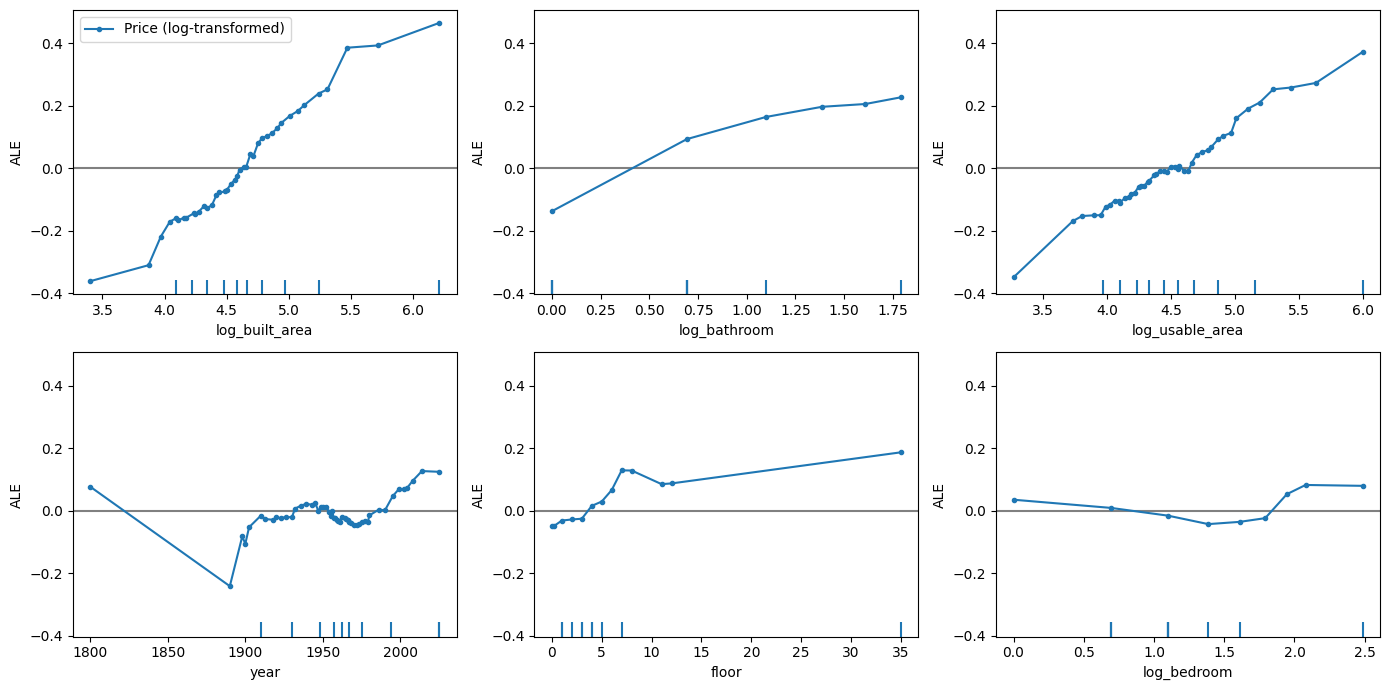

In [58]:
# ALE explainer with all the columns
catboost_ale = ALE(
    predictor=final_model.predict,
    feature_names=X_train.columns.tolist(),
    target_names=['Price (log-transformed)'],
)

# Explain all the X_train
catboost_exp = catboost_ale.explain(X_train.values)

# Only show in plots the top features by Feature Importance
top_features = ['log_built_area', 'log_bathroom', 'log_usable_area', 
                'year', 'floor', 'log_bedroom']

plot_ale(catboost_exp, features=top_features, n_cols=3, fig_kw={'figwidth': 14, 'figheight': 7})



With ALE we can see how the prediction changes when we change the features. So with this plots we can clearly conclude that: 
- The prediction of the price of the house increases in a linear way when the built area increases.
- The prediction of the price of the house increases with the number of bathroom (not as much as with the built area)
- The prediction of the price of the house increases in a linear way when the usable area increases. 

On the other hand we have the year, floor and number of bedrooms which may not be as easy to interpret: 
- As we can see the prediction between the year and the price is not directly proportional. Between 1800 and 1900, there are no examples in the dataset (only one for 1800), so the model’s predictions in this range are unreliable. So the apparent decrease in predicted price from 1800 to 1900 is driven by the single data points and should not be interpreted as a true trend; 1900 onwards, we can see that the price tends to be higher for newest houses but is not a linear relation, for example the model predicts a more expensive price for houses in 1950 than for houses of 1970.

- The model predicts a more expensive price usually with a higher floor, not always since the model provides a cheaper prediction for the houses of 10 floor than houses of 5 floor. Between the 12th and 35th floor, there are no examples, with only one observation at the 35th floor. The model predicts a higher price for this single example, which creates an apparent increasing trend in this range. As in the case of year, this pattern should not be interpreted as a real effect, as it is driven by sparse data.

- For the number of bedrooms, the predicted price does not show a clear pattern, as it varies across different numbers of bedrooms. In some cases, an increase in the number of bedrooms leads to a higher predicted price, while in others it leads to a lower predicted price. This reflects the variability in the model’s predictions for this feature. Note that the predictions are based on the logarithmic transformation of the number of bedrooms, so the effect is interpreted in log-space.

### LOCAL SHAP

In [51]:
import shap

Waterfall Plot

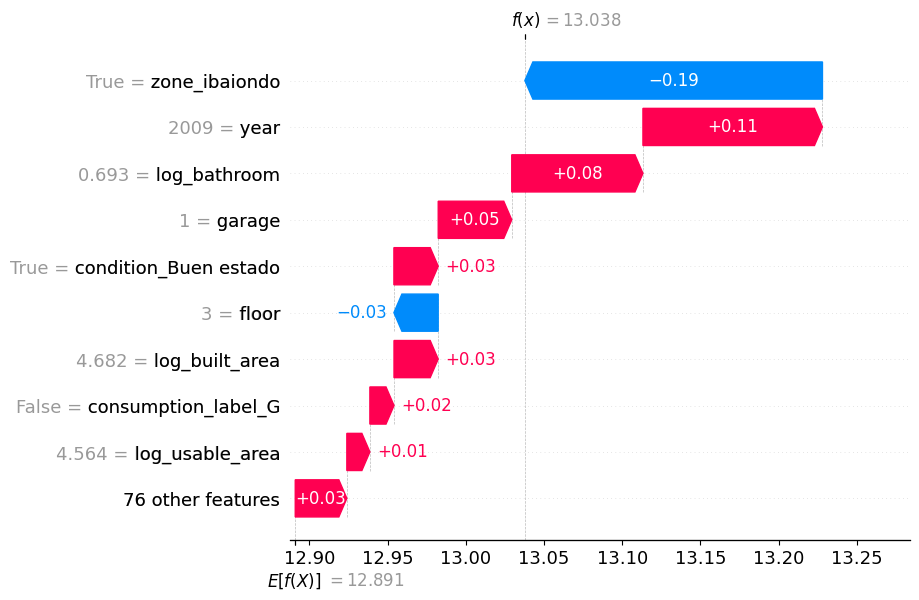

In [57]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)


shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_train.iloc[0],
    feature_names=X_train.columns.tolist()
))






We transform the expected prediction and the real prediction price to original scale
- E[f(x)] --> Expected prediction of the model = average prediction of the model (without taking into account any specific feature value)

In [61]:
print(f"Expected prediction price: {round(np.exp(12.891),2)} €")
print(f"Real prediction price: {round(np.exp(13.038),2)} €")

Expected prediction price: 396725.55 €
Real prediction price: 459548.61 €


For the first prediction, the zone ibaiondo and floor features push the predicted price downward, while the other features push it upward. The largest positive contributions come from year area and bathroom number, indicating these features strongly increase the predicted price for this house. Starting from the model’s expected a price of 396725.55 €, the combined contributions result in a price of 459548.61 €. It is important to note that these contributions describe this specific prediction and may vary for other houses.

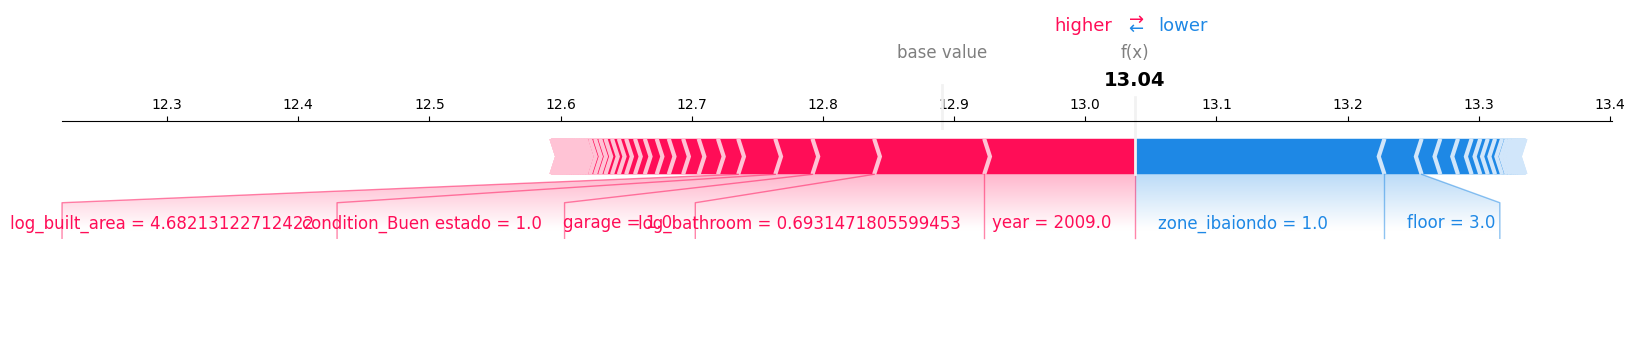

In [58]:
# FORCE PLOT (local)
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_train.iloc[0],
    matplotlib=True
)

In this plot we can see what we described above more clearly

Global Shap with bar plot - Like Catboost Feature Importance but considering interactions between features

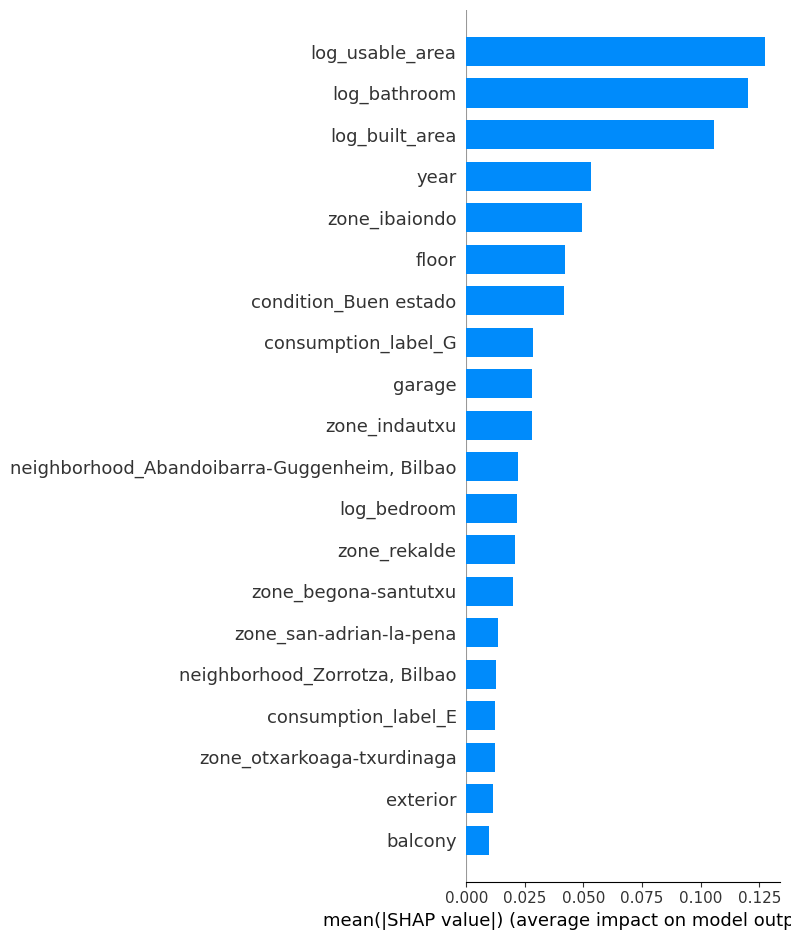

In [64]:
# BAR PLOT (global)
shap.summary_plot(shap_values, X_train, plot_type="bar")


As we can see the feature importance with SHAP has a different order to the one with Catboost Feature importance, since SHAP takes into account interaction between features. This makes more sense the results with Catboost FI since in real market, usable area is more important in defining the price than number of bahtrooms itself. 

 Global Shap with dot plot - Like the shap feature importance bar plot but including direction

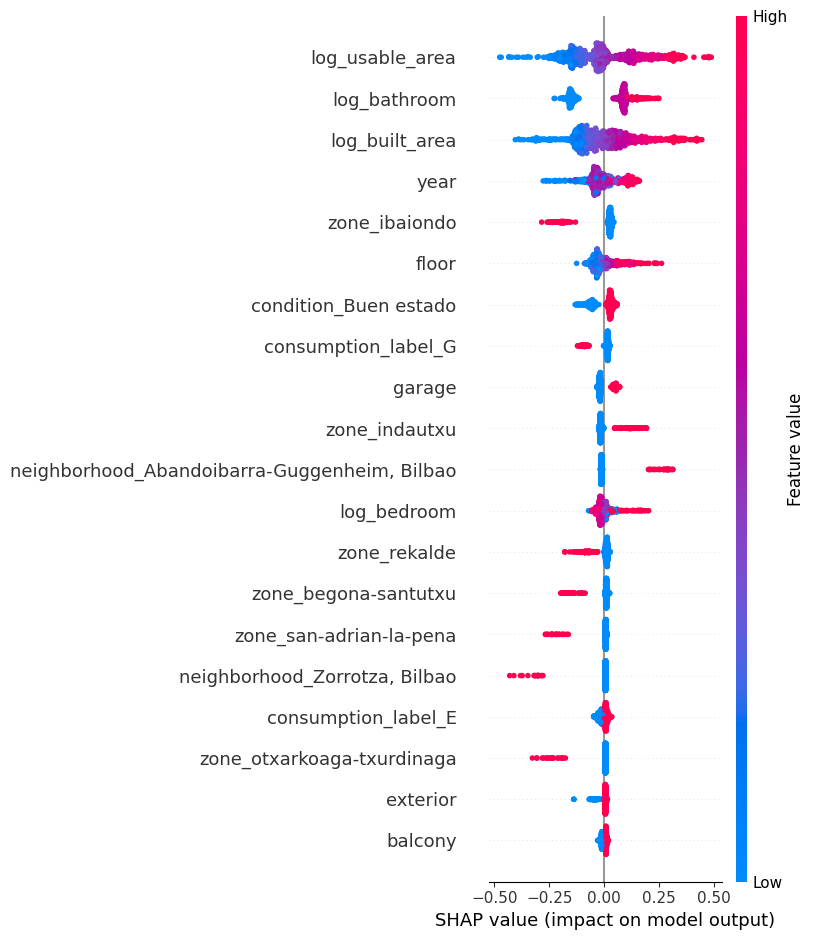

In [65]:
shap.summary_plot(shap_values, X_train)  # dot plot


This plot shows the Feature Importance with SHAP (as the one before) but including the direction, for example in this plot we can see that high usable are have a positive impact on the price prediction while low usable are have a negative impact. An interesting thing to notice is that the impact on the price prediction is strongly positive or strongly negative depending on the zone, for example a more expensive and centric zone like Indautxu has a stronger positive impact than a cheaper and peripheral zone like otxarkoaga txurdinaga which has a strong negative impact. 

# 9) Final Short Conclusion

In conclusion we have not achieved a model with the initial MAPE of 10% we set, however we have achieved a model with a near MAPE of 15%. Based on ALE and SHAP analyses, the model’s predictions align reasonably well with the key features that define house prices in the real market.